# Data Mining Final Project

Nuno Penim - 20210998

Paulo Oliveira - 20211002

Gonçalo Gomes - 20211007

### Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
from kmodes.kprototypes import KPrototypes as KP
import matplotlib.cm as cm
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.base import clone
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import dendrogram
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
import graphviz
from collections import Counter
import sompy
from sompy.visualization.mapview import View2D
from sompy.visualization.bmuhits import BmuHitsView
from sompy.visualization.hitmap import HitMapView

### Loading the sas7bdat data

In [2]:
df = pd.read_sas("a2z_insurance.sas7bdat")
df.head(5)

,CustID,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
0,1.0,1985.0,1982.0,b'2 - High School',2177.0,1.0,1.0,380.97,0.39,375.85,79.45,146.36,47.01,16.89
1,2.0,1981.0,1995.0,b'2 - High School',677.0,4.0,1.0,-131.13,1.12,77.46,416.20,116.69,194.48,106.13
2,3.0,1991.0,1970.0,b'1 - Basic',2277.0,3.0,0.0,504.67,0.28,206.15,224.50,124.58,86.35,99.02
3,4.0,1990.0,1981.0,b'3 - BSc/MSc',1099.0,4.0,1.0,-16.99,0.99,182.48,43.35,311.17,35.34,28.34
4,5.0,1986.0,1973.0,b'3 - BSc/MSc',1763.0,4.0,1.0,35.23,0.90,338.62,47.80,182.59,18.78,41.45


### Obtaining the column data types, for further analysis

In [3]:
len(df)

10296

In [4]:
df.dtypes

CustID           float64
FirstPolYear     float64
BirthYear        float64
EducDeg           object
MonthSal         float64
GeoLivArea       float64
Children         float64
CustMonVal       float64
ClaimsRate       float64
PremMotor        float64
PremHousehold    float64
PremHealth       float64
PremLife         float64
PremWork         float64
dtype: object

From this, combined with the work sheet gived, we can extract the following information about the datatypes:

| Variable Name | Datatype | Description |
| ----------- |:------------:| ---------------:|
| CustID | float64 | Customer ID |
| FirstPolYear | float64 | First year as a customer |
| BirthYear | float64 | Customer's Birthday Year |
| EducDeg | object | Customer's Academic Degree |
| MonthSal | float64 | Gross Salary (Monthly) |
| GeoLivArea | float64 | Living Area |
| Children | float64 | Binary variable of children |
| CustMonVal | float64 | Customer Monetary Value |
| ClaimsRate | float64 | Amount paid by the insurance company |
| PremMotor | float64 | Annual premiums in Motor |
| PremHousehold | float64 | Annual premiums in Household |
| PremHealth | float64| Annual premiums in Health |
| PremLife | float64 | Annual premiums in Life |
| PremWork | float64 | Annual premiums in Work Compensations |

### Data preparation

In [5]:
df["CustID"] = df["CustID"].astype(int)

In [6]:
df.set_index('CustID', inplace=True)

Remove duplicated values

In [7]:
print("Duplicate rows: " + str(df.duplicated().sum()))
df = df.drop_duplicates(keep = 'first')

Duplicate rows: 3


In [8]:
df.isnull().sum()

FirstPolYear      30
BirthYear         17
EducDeg           17
MonthSal          36
GeoLivArea         1
Children          21
CustMonVal         0
ClaimsRate         0
PremMotor         34
PremHousehold      0
PremHealth        43
PremLife         104
PremWork          86
dtype: int64

In [9]:
# We do this step here in order to perform coherence check on the EducDeg variable

#removed 17 null values
df.dropna(subset = ['EducDeg'], inplace=True)

In [10]:
df['EducDeg'] = df['EducDeg'].str.decode("utf-8")
df['EducDeg'] = df.EducDeg.apply(lambda x: int(x[0]))

In [11]:
df.head(4)

,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
CustID,,,,,,,,,,,,,
1,1985.0,1982.0,2,2177.0,1.0,1.0,380.97,0.39,375.85,79.45,146.36,47.01,16.89
2,1981.0,1995.0,2,677.0,4.0,1.0,-131.13,1.12,77.46,416.20,116.69,194.48,106.13
3,1991.0,1970.0,1,2277.0,3.0,0.0,504.67,0.28,206.15,224.50,124.58,86.35,99.02
4,1990.0,1981.0,3,1099.0,4.0,1.0,-16.99,0.99,182.48,43.35,311.17,35.34,28.34


In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
FirstPolYear,10261.0,1991.066270,511.392431,1974.00,1980.000,1986.00,1992.000,53784.00
BirthYear,10259.0,1968.018910,19.711683,1028.00,1953.000,1968.00,1983.000,2001.00
EducDeg,10276.0,2.479077,0.795639,1.00,2.000,3.00,3.000,4.00
MonthSal,10241.0,2505.767308,1157.729484,333.00,1705.000,2500.00,3290.000,55215.00
GeoLivArea,10275.0,2.709781,1.266071,1.00,1.000,3.00,4.000,4.00
Children,10255.0,0.706972,0.455173,0.00,0.000,1.00,1.000,1.00
CustMonVal,10276.0,177.823446,1947.683378,-165680.42,-9.465,186.87,399.495,11875.89
ClaimsRate,10276.0,0.742958,2.919768,0.00,0.390,0.72,0.980,256.20
PremMotor,10242.0,300.492349,212.027094,-4.11,190.590,298.61,408.300,11604.42
PremHousehold,10276.0,210.559790,352.884514,-75.00,49.450,132.80,290.600,25048.80


In [13]:
#CustMonVal min muito a baixo do 25 percentil
#birthYear min é 1028??

In [14]:
df.GeoLivArea.unique()

array([ 1.,  4.,  3.,  2., nan])

In [15]:
df.BirthYear.unique()

array([1982., 1995., 1970., 1981., 1973., 1956., 1943., 1974., 1978.,
       1948., 1945., 1958., 1949., 2000., 1975., 1979., 1989., 1962.,
       1986., 1961., 1952., 1944., 1937., 1942., 1972., 1953., 1966.,
       1955., 1941., 1938., 1968., 1990., 1984., 1980., 1946., 1965.,
       1957., 1967., 1977., 1951., 1985., 1959., 1988., 1983., 1939.,
       1964., 1950., 1960., 1976., 1971., 1954., 1969., 1994., 1992.,
       1997., 1963., 1991., 1999., 1993., 1947., 1987., 1996., 1940.,
       1935., 1936.,   nan, 1998., 2001., 1028.])

In [16]:
df.Children.unique()

array([ 1.,  0., nan])

### coherence checking

In [17]:
# Creating new variables related to the coherence of each of the features --> 1 if incoherent and 0 if not

In [18]:
# BirthYear
# Taking into account that the oldest person alive is 118 years old

df['coherence_birthyear']=df['BirthYear'].apply(lambda x: 1 if (x>2021 or x<1903) else 0)

In [19]:
# first year of insurance
# We cant have insurances created before the person was born

df['coherence_firstpolyear'] = df.apply(lambda x: 1 if x.FirstPolYear < x.BirthYear or x.FirstPolYear > 2021 or x.FirstPolYear < 1903 else 0, axis=1) 

In [20]:
# Age
# minimum legal age in Portugal is 14 years old so we cant have underage people making insurances

df['coherence_age'] = df.apply(lambda x: 1 if (2021-x.BirthYear < 14) else 0, axis=1)

In [21]:
# EducDeg
# It doesnt seem very valid to us that people under 18 have university degree

df['coherence_educdeg']=df.apply(lambda x:1 if (2021-x.BirthYear<=18 and x.EducDeg > 3) else 0, axis=1)

In [22]:
df.head(5)

,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,coherence_birthyear,coherence_firstpolyear,coherence_age,coherence_educdeg
CustID,,,,,,,,,,,,,,,,,
1,1985.0,1982.0,2,2177.0,1.0,1.0,380.97,0.39,375.85,79.45,146.36,47.01,16.89,0,0,0,0
2,1981.0,1995.0,2,677.0,4.0,1.0,-131.13,1.12,77.46,416.20,116.69,194.48,106.13,0,1,0,0
3,1991.0,1970.0,1,2277.0,3.0,0.0,504.67,0.28,206.15,224.50,124.58,86.35,99.02,0,0,0,0
4,1990.0,1981.0,3,1099.0,4.0,1.0,-16.99,0.99,182.48,43.35,311.17,35.34,28.34,0,0,0,0
5,1986.0,1973.0,3,1763.0,4.0,1.0,35.23,0.90,338.62,47.80,182.59,18.78,41.45,0,0,0,0


In [23]:
df.coherence_birthyear.value_counts()

0    10275
1        1
Name: coherence_birthyear, dtype: int64

In [24]:
df.coherence_firstpolyear.value_counts()

0    8279
1    1997
Name: coherence_firstpolyear, dtype: int64

In [25]:
df.coherence_age.value_counts()

0    10276
Name: coherence_age, dtype: int64

In [26]:
df.coherence_educdeg.value_counts()

0    10276
Name: coherence_educdeg, dtype: int64

In [27]:
# we don't drop coherence_firstpolyear because it has a lot of observations
# these values may be associated with insurance transfers between family members etc. Because of that, we consider these observations still valid

df = df[df.coherence_birthyear != 1]
df = df[df.coherence_age != 1]
df = df[df.coherence_educdeg != 1]
del df['coherence_birthyear']
del df['coherence_firstpolyear']
del df['coherence_age']
del df['coherence_educdeg']

In [28]:
df.head(5)

,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
CustID,,,,,,,,,,,,,
1,1985.0,1982.0,2,2177.0,1.0,1.0,380.97,0.39,375.85,79.45,146.36,47.01,16.89
2,1981.0,1995.0,2,677.0,4.0,1.0,-131.13,1.12,77.46,416.20,116.69,194.48,106.13
3,1991.0,1970.0,1,2277.0,3.0,0.0,504.67,0.28,206.15,224.50,124.58,86.35,99.02
4,1990.0,1981.0,3,1099.0,4.0,1.0,-16.99,0.99,182.48,43.35,311.17,35.34,28.34
5,1986.0,1973.0,3,1763.0,4.0,1.0,35.23,0.90,338.62,47.80,182.59,18.78,41.45


In [29]:
#BirthYear might be useless we will leave it for now

### Missing value treatment

In [30]:
df.isnull().sum()

FirstPolYear      15
BirthYear         17
EducDeg            0
MonthSal          35
GeoLivArea         1
Children          21
CustMonVal         0
ClaimsRate         0
PremMotor         34
PremHousehold      0
PremHealth        42
PremLife         104
PremWork          85
dtype: int64

In [31]:
# Regarding the premiums we replace the null values with 0, with the assumption that the client didnt do any insurance related to that feature

df['PremMotor'].fillna(0, inplace = True)
df['PremHousehold'].fillna(0, inplace = True)
df['PremHealth'].fillna(0, inplace = True)
df['PremLife'].fillna(0, inplace = True)
df['PremWork'].fillna(0, inplace = True)

In [32]:
# Only one null observation with GeoLivArea so we drop it

df.dropna(subset = ['GeoLivArea'], inplace = True)

In [33]:
# We dont have any reasonable solution to treat the missing values in "FirstPolYear" so we decided to drop them

df.dropna(subset = ['FirstPolYear'], inplace = True)
df.dropna(subset = ['BirthYear'], inplace = True)

In [34]:
# We dont have any reasonable solution to treat the missing values in "FirstPolYear" so we decided to drop them
df.dropna(subset = ['Children'], inplace = True)

In [35]:
testX = df[df['MonthSal'].isnull()]
del testX ['MonthSal']
trainX = pd.concat([df, testX, testX]).drop_duplicates(keep=False)
trainy = trainX['MonthSal']
del trainX ['MonthSal']

In [36]:
model = RandomForestRegressor()
model.fit(trainX,trainy)
predictions = model.predict(testX)

In [37]:
indexes = df[df['MonthSal'].isnull()].index
count = 0
for i in indexes:
    df['MonthSal'][i] = predictions[count]
    count += 1 

C:\Users\Ricardo\AppData\Local\Temp/ipykernel_2412/3826756920.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MonthSal'][i] = predictions[count]


In [38]:
df.isnull().sum()

FirstPolYear     0
BirthYear        0
EducDeg          0
MonthSal         0
GeoLivArea       0
Children         0
CustMonVal       0
ClaimsRate       0
PremMotor        0
PremHousehold    0
PremHealth       0
PremLife         0
PremWork         0
dtype: int64

In [39]:
len(df)

10233

### Outliers

findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05
findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 4

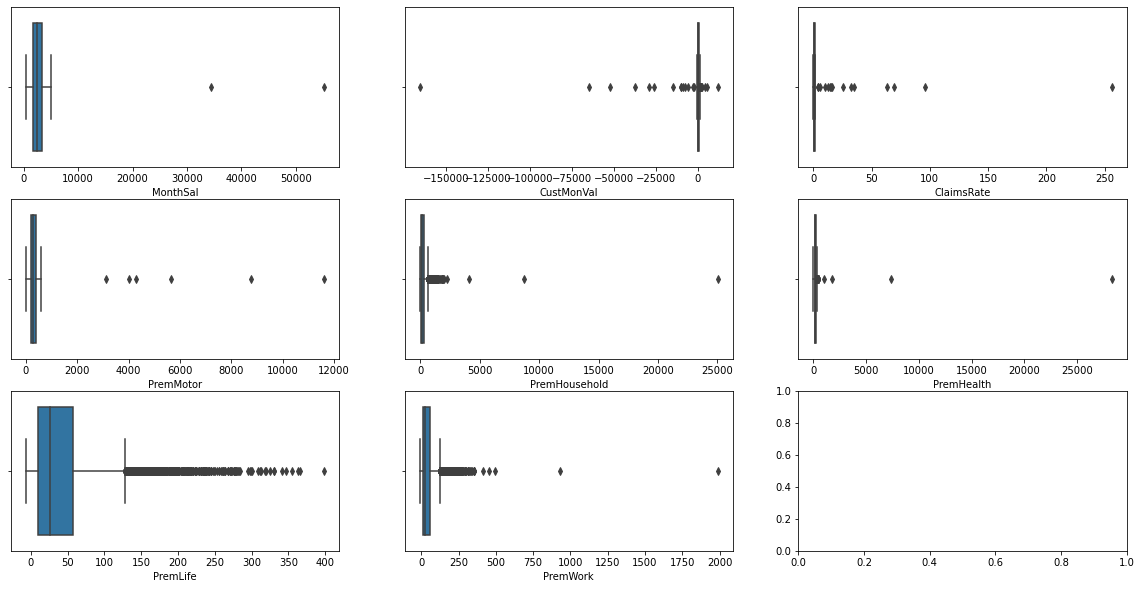

In [40]:
fig, ax =plt.subplots(3,3, figsize=(20, 10))
sns.boxplot(data = df, x = 'MonthSal', ax=ax[0][0])

sns.boxplot(data = df, x = 'CustMonVal', ax=ax[0][1])

sns.boxplot(data = df, x = 'ClaimsRate', ax=ax[0][2])

sns.boxplot(data = df, x = 'PremMotor', ax=ax[1][0])

sns.boxplot(data = df, x = 'PremHousehold', ax=ax[1][1])

sns.boxplot(data = df, x = 'PremHealth', ax=ax[1][2])

sns.boxplot(data = df, x = 'PremLife', ax=ax[2][0])

sns.boxplot(data = df, x = 'PremWork', ax=ax[2][1])

plt.show()

In [41]:
month_outliers = df[(df.MonthSal > 10000)]
len(month_outliers)

2

In [42]:
custmonval_outliers = df[(df.CustMonVal < -25000)]
len(custmonval_outliers)

6

In [43]:
claimsrate_outliers = df[(df.ClaimsRate > 50)]
len(claimsrate_outliers)

4

In [44]:
premmotor_outliers = df[(df.PremMotor > 2000)]
len(premmotor_outliers)

6

In [45]:
premhousehold_outliers = df[(df.PremHousehold > 4000)]
len(premhousehold_outliers)

3

In [46]:
premhealth_outliers = df[(df.PremHealth > 5000)]
len(premhealth_outliers)

2

In [47]:
premlife_outliers = df[(df.PremLife > 390)]
len(premlife_outliers)

1

In [48]:
premwork_outliers = df[(df.PremWork > 750)]
len(premwork_outliers)

2

In [49]:
df = df[~(df.MonthSal > 10000)]
df = df[~(df.CustMonVal < -25000)]
df = df[~(df.ClaimsRate > 50)]
df = df[~(df.PremMotor > 2000)]
df = df[~(df.PremHousehold > 4000)]
df = df[~(df.PremHealth > 5000)]
df = df[~(df.PremLife > 390)]
df = df[~(df.PremWork > 750)]

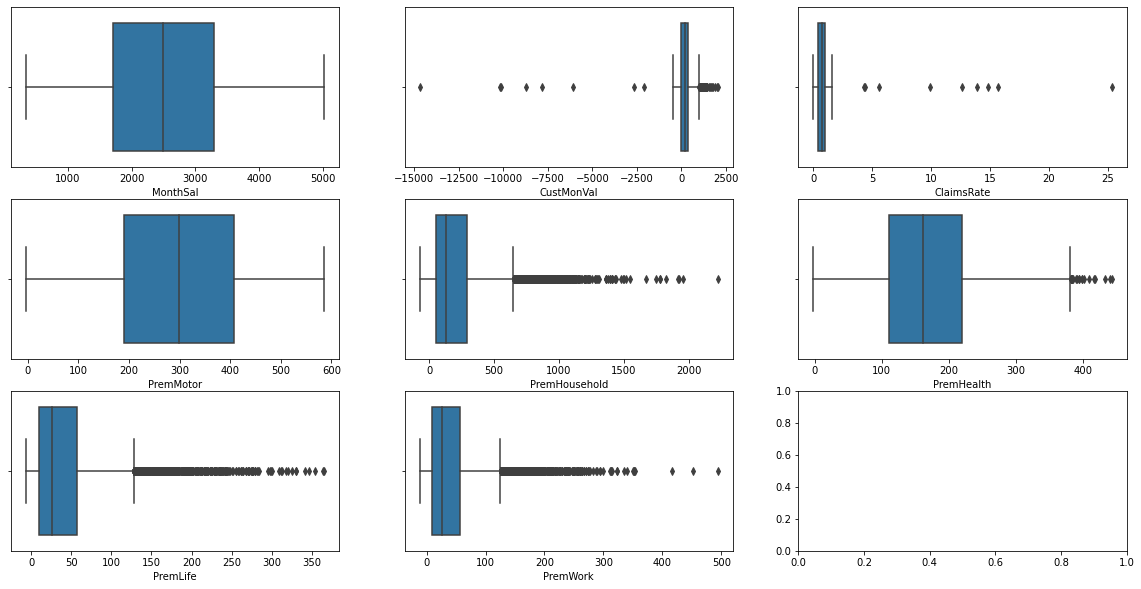

In [50]:
fig, ax =plt.subplots(3,3, figsize=(20, 10))
sns.boxplot(data = df, x = 'MonthSal', ax=ax[0][0])

sns.boxplot(data = df, x = 'CustMonVal', ax=ax[0][1])

sns.boxplot(data = df, x = 'ClaimsRate', ax=ax[0][2])

sns.boxplot(data = df, x = 'PremMotor', ax=ax[1][0])

sns.boxplot(data = df, x = 'PremHousehold', ax=ax[1][1])

sns.boxplot(data = df, x = 'PremHealth', ax=ax[1][2])

sns.boxplot(data = df, x = 'PremLife', ax=ax[2][0])

sns.boxplot(data = df, x = 'PremWork', ax=ax[2][1])

plt.show()

In [51]:
len(df)

10212

### Correlations

In [52]:
def cor_heatmap(cor):
    plt.figure(figsize=(12,10))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()

In [53]:
corr_df = df.drop(columns=['EducDeg', 'GeoLivArea', 'Children'])
correlations = corr_df.corr(method='spearman')

locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000027D92CD4EB0>
Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000027D92CD4EB0> on colorbar
Setting pcolormesh


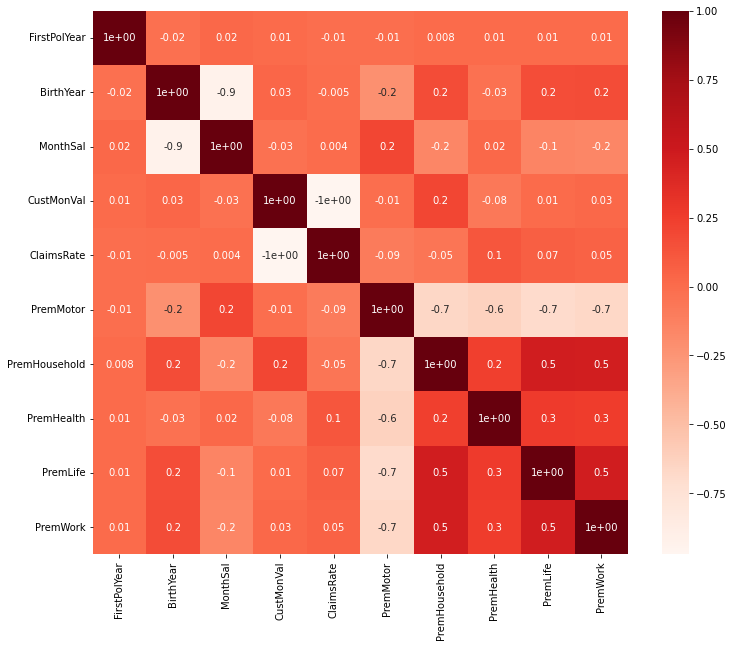

In [54]:
cor_heatmap(correlations)

In [55]:
# Deleting high correlated variables

# Corrleation of -1 with "CustMonVal" and also being more corelated with other variables when compared to CustMonVal
del df['ClaimsRate']

# Correlation of -0.9 with monthSal and also being more corelated with other variables when compared to "MonthSal"
del df["BirthYear"]

In [56]:
df.head()

,FirstPolYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
CustID,,,,,,,,,,,
1,1985.0,2,2177.0,1.0,1.0,380.97,375.85,79.45,146.36,47.01,16.89
2,1981.0,2,677.0,4.0,1.0,-131.13,77.46,416.20,116.69,194.48,106.13
3,1991.0,1,2277.0,3.0,0.0,504.67,206.15,224.50,124.58,86.35,99.02
4,1990.0,3,1099.0,4.0,1.0,-16.99,182.48,43.35,311.17,35.34,28.34
5,1986.0,3,1763.0,4.0,1.0,35.23,338.62,47.80,182.59,18.78,41.45


### Feature Engineering

In [57]:
# date of the years to the number of the years

df['FirstPolYear'] = df.apply(lambda x: 2021 - x.FirstPolYear, axis=1)

# Monthly to anual

df['MonthSal'] = df.apply(lambda x: x.MonthSal * 12, axis=1)
df['CustMonVal'] = df.apply(lambda x: x.CustMonVal * 12, axis=1)

In [58]:
df.rename(columns = {'FirstPolYear':'FirstPolAge' , 'MonthSal':'YearSal', 'CustMonVal':'CustYearVal'}, inplace = True)

In [59]:
df.head(5)

,FirstPolAge,EducDeg,YearSal,GeoLivArea,Children,CustYearVal,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
CustID,,,,,,,,,,,
1,36.0,2,26124.0,1.0,1.0,4571.64,375.85,79.45,146.36,47.01,16.89
2,40.0,2,8124.0,4.0,1.0,-1573.56,77.46,416.20,116.69,194.48,106.13
3,30.0,1,27324.0,3.0,0.0,6056.04,206.15,224.50,124.58,86.35,99.02
4,31.0,3,13188.0,4.0,1.0,-203.88,182.48,43.35,311.17,35.34,28.34
5,35.0,3,21156.0,4.0,1.0,422.76,338.62,47.80,182.59,18.78,41.45


In [60]:
# Creating a variable that accounts for the percentage of premium insurances in regards to the anual salary

df['PremiumSalaryRate'] = df.apply(lambda x: (x.PremMotor + x.PremHousehold + x.PremHealth + x.PremLife + x.PremWork) / x.YearSal, axis=1)

In [61]:
df.head()

,FirstPolAge,EducDeg,YearSal,GeoLivArea,Children,CustYearVal,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,PremiumSalaryRate
CustID,,,,,,,,,,,,
1,36.0,2,26124.0,1.0,1.0,4571.64,375.85,79.45,146.36,47.01,16.89,0.025477
2,40.0,2,8124.0,4.0,1.0,-1573.56,77.46,416.20,116.69,194.48,106.13,0.112132
3,30.0,1,27324.0,3.0,0.0,6056.04,206.15,224.50,124.58,86.35,99.02,0.027104
4,31.0,3,13188.0,4.0,1.0,-203.88,182.48,43.35,311.17,35.34,28.34,0.045547
5,35.0,3,21156.0,4.0,1.0,422.76,338.62,47.80,182.59,18.78,41.45,0.029743


In [62]:
corr_df = df.drop(columns=['EducDeg', 'GeoLivArea', 'Children'])
correlations = corr_df.corr(method='spearman')

locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000027D93370B80>
Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x0000027D93370B80> on colorbar
Setting pcolormesh


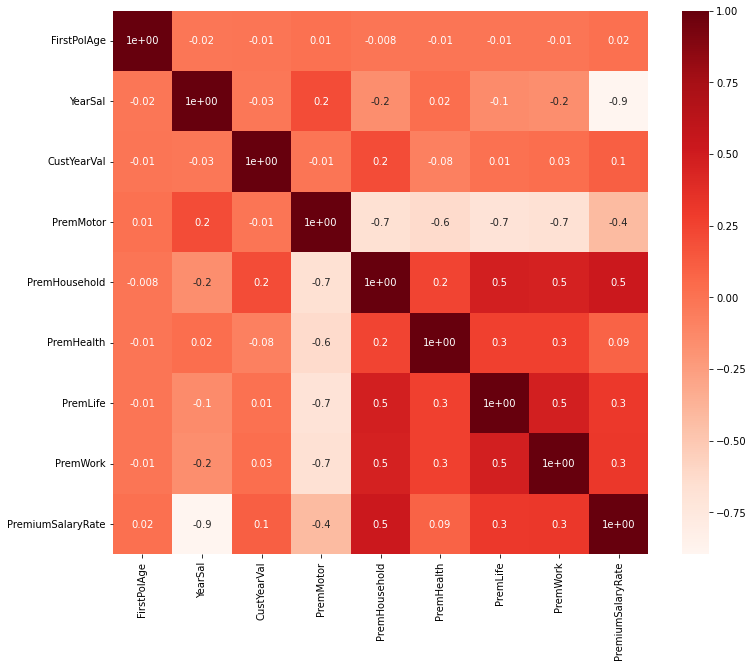

In [63]:
cor_heatmap(correlations)

In [64]:
# Negative correlation with YearSal

del df['PremiumSalaryRate']

### Data Normalization

In [65]:
metric_features = ['FirstPolAge', 'YearSal', 'CustYearVal', 'PremMotor', 'PremHousehold', 'PremHealth', 'PremLife', 'PremWork']

In [66]:
df_minmax = df.copy()
# Use MinMaxScaler to scale the data
scaler = MinMaxScaler()
scaled_feat = scaler.fit_transform(df_minmax[metric_features])
scaled_feat

array([[0.99978769, 0.39334471, 0.90022155, ..., 0.33366294, 0.14511795,
        0.05708358],
       [0.99986489, 0.07337884, 0.86968151, ..., 0.26698429, 0.54135096,
        0.23341237],
       [0.99967188, 0.41467577, 0.90759863, ..., 0.28471582, 0.2508195 ,
        0.21936376],
       ...,
       [0.99961397, 0.55140785, 0.90875738, ..., 0.32442637, 0.05285077,
        0.03337285],
       [0.99986489, 0.34940273, 0.89241389, ..., 0.45054723, 0.19049922,
        0.24680893],
       [0.99969118, 0.52943686, 0.90515829, ..., 0.32217902, 0.03732065,
        0.04918   ]])

In [67]:
df_minmax[metric_features] = scaled_feat
df_minmax.head()

,FirstPolAge,EducDeg,YearSal,GeoLivArea,Children,CustYearVal,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
CustID,,,,,,,,,,,
1,0.999788,2,0.393345,1.0,1.0,0.900222,0.644732,0.067189,0.333663,0.145118,0.057084
2,0.999865,2,0.073379,4.0,1.0,0.869682,0.138411,0.213681,0.266984,0.541351,0.233412
3,0.999672,1,0.414676,3.0,0.0,0.907599,0.356778,0.130288,0.284716,0.250819,0.219364
4,0.999691,3,0.163396,4.0,1.0,0.876488,0.316614,0.051485,0.704047,0.113762,0.079708
5,0.999768,3,0.305034,4.0,1.0,0.879603,0.581559,0.053420,0.415084,0.069268,0.105612


In [68]:
df = df_minmax.copy()

### One-hot encoding

In [69]:
df_ohc = df.copy()

In [70]:
non_metric_features = ['EducDeg', 'GeoLivArea', 'Children']

In [71]:
ohc = OneHotEncoder(sparse=False, drop="first")
ohc_feat = ohc.fit_transform(df_ohc[non_metric_features])
ohc_feat_names = ohc.get_feature_names()
ohc_df = pd.DataFrame(ohc_feat, index=df_ohc.index, columns=ohc_feat_names) 
ohc_df

C:\Users\Ricardo\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,x0_2,x0_3,x0_4,x1_2.0,x1_3.0,x1_4.0,x2_1.0
CustID,,,,,,,
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,1.0,1.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,1.0,1.0
5,0.0,1.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...
10292,0.0,0.0,1.0,1.0,0.0,0.0,0.0
10293,0.0,0.0,0.0,0.0,1.0,0.0,0.0
10294,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [72]:
# Reassigning df to contain ohc variables
df_ohc = pd.concat([df_ohc.drop(columns=non_metric_features), ohc_df], axis=1)
df_ohc.head()

,FirstPolAge,YearSal,CustYearVal,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,x0_2,x0_3,x0_4,x1_2.0,x1_3.0,x1_4.0,x2_1.0
CustID,,,,,,,,,,,,,,,
1,0.999788,0.393345,0.900222,0.644732,0.067189,0.333663,0.145118,0.057084,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.999865,0.073379,0.869682,0.138411,0.213681,0.266984,0.541351,0.233412,1.0,0.0,0.0,0.0,0.0,1.0,1.0
3,0.999672,0.414676,0.907599,0.356778,0.130288,0.284716,0.250819,0.219364,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.999691,0.163396,0.876488,0.316614,0.051485,0.704047,0.113762,0.079708,0.0,1.0,0.0,0.0,0.0,1.0,1.0
5,0.999768,0.305034,0.879603,0.581559,0.053420,0.415084,0.069268,0.105612,0.0,1.0,0.0,0.0,0.0,1.0,1.0


In [73]:
df = df_ohc.copy()

### Dimensionality Reduction

In [74]:
df_pca = df.copy()

In [75]:
pca = PCA()
pca_feat = pca.fit_transform(df_pca[metric_features])
pca_feat  

array([[-1.19383199e-01, -1.04611616e-01, -2.85863287e-02, ...,
        -1.38867124e-02, -1.17592112e-02, -1.68002033e-04],
       [ 5.33749269e-01, -3.43232507e-01,  2.46131067e-01, ...,
         4.55262955e-03,  2.03191455e-02,  7.49175860e-05],
       [ 1.60102837e-01, -5.86924334e-02,  1.59520020e-01, ...,
         1.78943954e-02, -1.98296336e-02, -3.98233205e-05],
       ...,
       [-2.33447472e-01,  2.76212737e-02, -1.52399364e-02, ...,
        -3.02873616e-03, -1.79085660e-02, -5.18098685e-05],
       [ 2.47066462e-01, -4.28823140e-02, -2.33683190e-03, ...,
        -2.11603466e-02, -4.13075240e-03, -1.71504640e-04],
       [-2.46655139e-01,  4.35679816e-03, -3.18893790e-02, ...,
        -6.73252165e-03, -1.50776033e-02, -1.18318277e-04]])

In [76]:
# Output PCA table
pd.DataFrame(
    {"Eigenvalue": pca.explained_variance_,
     "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
     "Proportion": pca.explained_variance_ratio_,
     "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
    index=range(1, pca.n_components_ + 1)
)

,Eigenvalue,Difference,Proportion,Cumulative
1,0.085214,0.000000,0.519913,0.519913
2,0.042752,-0.042461,0.260845,0.780758
3,0.020583,-0.022170,0.125581,0.906338
4,0.008215,-0.012367,0.050124,0.956462
5,0.005663,-0.002553,0.034550,0.991012
6,0.000951,-0.004711,0.005805,0.996817
7,0.000424,-0.000528,0.002586,0.999403
8,0.000098,-0.000326,0.000597,1.000000


findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=14.0.
findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05
findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 4

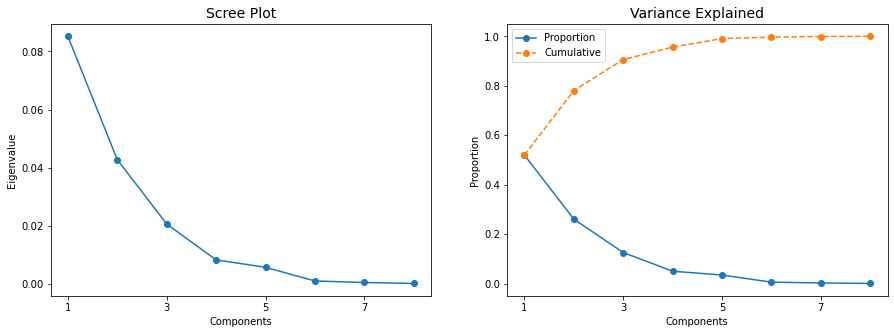

In [77]:
# figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# draw plots
ax1.plot(pca.explained_variance_, marker=".", markersize=12)
ax2.plot(pca.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
ax2.plot(np.cumsum(pca.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative")

# customizations
ax2.legend()
ax1.set_title("Scree Plot", fontsize=14)
ax2.set_title("Variance Explained", fontsize=14)
ax1.set_ylabel("Eigenvalue")
ax2.set_ylabel("Proportion")
ax1.set_xlabel("Components")
ax2.set_xlabel("Components")
ax1.set_xticks(range(0, pca.n_components_, 2))
ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))
ax2.set_xticks(range(0, pca.n_components_, 2))
ax2.set_xticklabels(range(1, pca.n_components_ + 1, 2))

plt.show()

In [78]:
# Perform PCA again with the number of principal components you want to retain
pca = PCA(n_components=3)
pca_feat = pca.fit_transform(df_pca[metric_features])
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]
pca_df = pd.DataFrame(pca_feat, index=df_pca.index, columns=pca_feat_names)  # remember index=df_pca.index
pca_df

,PC0,PC1,PC2
CustID,,,
1,-0.119383,-0.104612,-0.028586
2,0.533749,-0.343233,0.246131
3,0.160103,-0.058692,0.159520
4,0.327900,-0.094233,-0.340681
5,-0.030450,-0.135388,-0.135270
...,...,...,...
10292,-0.219719,0.111747,-0.055558
10293,0.285306,0.008748,0.175361
10294,-0.233447,0.027621,-0.015240


In [79]:
# Reassigning df to contain pca variables
df_pca = pd.concat([df_pca, pca_df], axis=1)
df_pca.head()

,FirstPolAge,YearSal,CustYearVal,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,x0_2,x0_3,x0_4,x1_2.0,x1_3.0,x1_4.0,x2_1.0,PC0,PC1,PC2
CustID,,,,,,,,,,,,,,,,,,
1,0.999788,0.393345,0.900222,0.644732,0.067189,0.333663,0.145118,0.057084,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.119383,-0.104612,-0.028586
2,0.999865,0.073379,0.869682,0.138411,0.213681,0.266984,0.541351,0.233412,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.533749,-0.343233,0.246131
3,0.999672,0.414676,0.907599,0.356778,0.130288,0.284716,0.250819,0.219364,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.160103,-0.058692,0.159520
4,0.999691,0.163396,0.876488,0.316614,0.051485,0.704047,0.113762,0.079708,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.327900,-0.094233,-0.340681
5,0.999768,0.305034,0.879603,0.581559,0.053420,0.415084,0.069268,0.105612,0.0,1.0,0.0,0.0,0.0,1.0,1.0,-0.030450,-0.135388,-0.135270


In [80]:
def _color_red_or_green(val):
    if val < -0.45:
        color = 'background-color: red'
    elif val > 0.45:
        color = 'background-color: green'
    else:
        color = ''
    return color

# Interpreting each Principal Component
loadings = df_pca[metric_features + pca_feat_names].corr().loc[metric_features, pca_feat_names]
loadings.style.applymap(_color_red_or_green)

,PC0,PC1,PC2
FirstPolAge,0.004993,-0.007653,0.003216
YearSal,-0.419436,0.878449,0.228717
CustYearVal,0.048532,-0.056468,0.122744
PremMotor,-0.974916,-0.181236,-0.095793
PremHousehold,0.627735,-0.075019,0.393067
PremHealth,0.598491,0.485280,-0.628702
PremLife,0.661519,-0.082440,0.495129
PremWork,0.614085,-0.076133,0.336154


In [81]:
df = df_pca.copy()

In [82]:
df.head(5)

,FirstPolAge,YearSal,CustYearVal,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,x0_2,x0_3,x0_4,x1_2.0,x1_3.0,x1_4.0,x2_1.0,PC0,PC1,PC2
CustID,,,,,,,,,,,,,,,,,,
1,0.999788,0.393345,0.900222,0.644732,0.067189,0.333663,0.145118,0.057084,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.119383,-0.104612,-0.028586
2,0.999865,0.073379,0.869682,0.138411,0.213681,0.266984,0.541351,0.233412,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.533749,-0.343233,0.246131
3,0.999672,0.414676,0.907599,0.356778,0.130288,0.284716,0.250819,0.219364,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.160103,-0.058692,0.159520
4,0.999691,0.163396,0.876488,0.316614,0.051485,0.704047,0.113762,0.079708,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.327900,-0.094233,-0.340681
5,0.999768,0.305034,0.879603,0.581559,0.053420,0.415084,0.069268,0.105612,0.0,1.0,0.0,0.0,0.0,1.0,1.0,-0.030450,-0.135388,-0.135270


In [83]:
pc_features = df.columns[df.columns.str.startswith('PC')]

### Before Clustering

In [84]:
# Splitting feature names into groups
non_metric_features = df.columns[df.columns.str.startswith('x')]
pc_features = df.columns[df.columns.str.startswith('PC')]
metric_features = df.columns[~df.columns.str.startswith('x') & ~df.columns.str.startswith('PC')]

### Outliers using DBscan

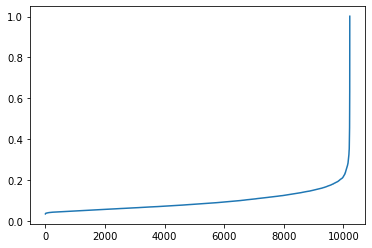

In [85]:
# Finding the epsilon parameter for dbscan
neigh = NearestNeighbors(n_neighbors=16)
neigh.fit(df[metric_features])
distances, _ = neigh.kneighbors(df[metric_features])
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.show()

# after the threshold defined by us, the observations have really high distances to their k nearest neighbour
# eps = 0.16

In [86]:
# Perform DBSCAN clustering
# Since we have 8 metric features, we set min_samples to 16
dbscan = DBSCAN(eps=0.16, min_samples=16, n_jobs=-1)
dbscan_labels = dbscan.fit_predict(df[metric_features])

dbscan_n_clusters = len(np.unique(dbscan_labels))
print("Number of estimated clusters : %d" % dbscan_n_clusters)

Number of estimated clusters : 2


In [87]:
df

,FirstPolAge,YearSal,CustYearVal,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,x0_2,x0_3,x0_4,x1_2.0,x1_3.0,x1_4.0,x2_1.0,PC0,PC1,PC2
CustID,,,,,,,,,,,,,,,,,,
1,0.999788,0.393345,0.900222,0.644732,0.067189,0.333663,0.145118,0.057084,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.119383,-0.104612,-0.028586
2,0.999865,0.073379,0.869682,0.138411,0.213681,0.266984,0.541351,0.233412,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.533749,-0.343233,0.246131
3,0.999672,0.414676,0.907599,0.356778,0.130288,0.284716,0.250819,0.219364,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.160103,-0.058692,0.159520
4,0.999691,0.163396,0.876488,0.316614,0.051485,0.704047,0.113762,0.079708,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.327900,-0.094233,-0.340681
5,0.999768,0.305034,0.879603,0.581559,0.053420,0.415084,0.069268,0.105612,0.0,1.0,0.0,0.0,0.0,1.0,1.0,-0.030450,-0.135388,-0.135270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10292,0.999807,0.609002,0.877495,0.675089,0.054138,0.395352,0.045086,0.052914,0.0,0.0,1.0,1.0,0.0,0.0,0.0,-0.219719,0.111747,-0.055558
10293,0.999942,0.447526,0.961327,0.233638,0.483197,0.326674,0.053442,0.231436,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.285306,0.008748,0.175361
10294,0.999614,0.551408,0.908757,0.691870,0.090397,0.324426,0.052851,0.033373,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-0.233447,0.027621,-0.015240


In [88]:
# We have 329 outliers that we will need to later reassign

Counter(dbscan_labels)

Counter({0: 9883, -1: 329})

In [89]:
# Putting all the outliers found until now in a new dataframe
df_out = df[dbscan_labels==-1].copy()

df = df[dbscan_labels!=-1]\
    .copy()
df

,FirstPolAge,YearSal,CustYearVal,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,x0_2,x0_3,x0_4,x1_2.0,x1_3.0,x1_4.0,x2_1.0,PC0,PC1,PC2
CustID,,,,,,,,,,,,,,,,,,
1,0.999788,0.393345,0.900222,0.644732,0.067189,0.333663,0.145118,0.057084,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.119383,-0.104612,-0.028586
2,0.999865,0.073379,0.869682,0.138411,0.213681,0.266984,0.541351,0.233412,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.533749,-0.343233,0.246131
3,0.999672,0.414676,0.907599,0.356778,0.130288,0.284716,0.250819,0.219364,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.160103,-0.058692,0.159520
4,0.999691,0.163396,0.876488,0.316614,0.051485,0.704047,0.113762,0.079708,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.327900,-0.094233,-0.340681
5,0.999768,0.305034,0.879603,0.581559,0.053420,0.415084,0.069268,0.105612,0.0,1.0,0.0,0.0,0.0,1.0,1.0,-0.030450,-0.135388,-0.135270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10291,0.999614,0.062500,0.888013,0.018665,0.414791,0.236510,0.322478,0.421379,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.638863,-0.343145,0.285486
10292,0.999807,0.609002,0.877495,0.675089,0.054138,0.395352,0.045086,0.052914,0.0,0.0,1.0,1.0,0.0,0.0,0.0,-0.219719,0.111747,-0.055558
10294,0.999614,0.551408,0.908757,0.691870,0.090397,0.324426,0.052851,0.033373,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-0.233447,0.027621,-0.015240


In [90]:
df_out

,FirstPolAge,YearSal,CustYearVal,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,x0_2,x0_3,x0_4,x1_2.0,x1_3.0,x1_4.0,x2_1.0,PC0,PC1,PC2
CustID,,,,,,,,,,,,,,,,,,
52,0.999846,0.618814,0.000000,0.952862,0.041327,0.071173,0.032242,0.005928,0.0,1.0,0.0,0.0,0.0,1.0,1.0,-0.572007,-0.057008,0.107421
99,0.999730,0.754480,0.888192,0.353571,0.068646,0.251995,0.517169,0.141632,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.096751,0.223825,0.380301
102,0.999865,0.503626,0.916558,0.113332,0.314715,0.477021,0.103310,0.332009,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.411495,0.143615,0.097676
113,0.999556,0.431101,0.357525,0.886481,0.034562,0.130368,0.029260,0.045228,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.436102,-0.190456,0.023252
136,0.999556,0.393131,0.269271,0.511971,0.103448,0.326921,0.385486,0.017783,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.050315,-0.088543,0.092886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10058,0.999826,0.263652,0.890777,0.406750,0.124481,0.004742,0.105702,0.159632,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.014950,-0.304600,0.228825
10113,0.999633,0.720137,0.903410,0.138598,0.290549,0.266984,0.638401,0.062359,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.350201,0.231701,0.490449
10153,0.999923,0.302261,0.894985,0.228361,0.150582,0.241005,0.746494,0.117250,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.407550,-0.172075,0.375327


### Visualization of the Input Space using SOM

In [91]:
np.random.seed(42)

sm = sompy.SOMFactory().build(
    df[metric_features].values, 
    mapsize=[10, 10],  
    initialization='random', 
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
    component_names=metric_features
)
sm.train(n_job=4, verbose='info', train_rough_len=100, train_finetune_len=100)

 Training...
 random_initialization took: 0.000000 seconds
 Rough training...
 radius_ini: 4.000000 , radius_final: 1.000000, trainlen: 100

 epoch: 1 ---> elapsed time:  0.015000, quantization error: 3.507380

 epoch: 2 ---> elapsed time:  0.013000, quantization error: 2.607268

 epoch: 3 ---> elapsed time:  0.013000, quantization error: 2.557589

 epoch: 4 ---> elapsed time:  0.014000, quantization error: 2.522606

 epoch: 5 ---> elapsed time:  0.014000, quantization error: 2.487321

 epoch: 6 ---> elapsed time:  0.014000, quantization error: 2.476036

 epoch: 7 ---> elapsed time:  0.014000, quantization error: 2.468976

 epoch: 8 ---> elapsed time:  0.014000, quantization error: 2.460537

 epoch: 9 ---> elapsed time:  0.013000, quantization error: 2.445516

 epoch: 10 ---> elapsed time:  0.014000, quantization error: 2.434476

 epoch: 11 ---> elapsed time:  0.014000, quantization error: 2.430385

 epoch: 12 ---> elapsed time:  0.014000, quantization error: 2.427027

 epoch: 13 ---> 

C:\Users\Ricardo\anaconda3\lib\site-packages\sompy\visualization\plot_tools.py:45: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(shape[0], shape[1], comp + 1, aspect='equal')


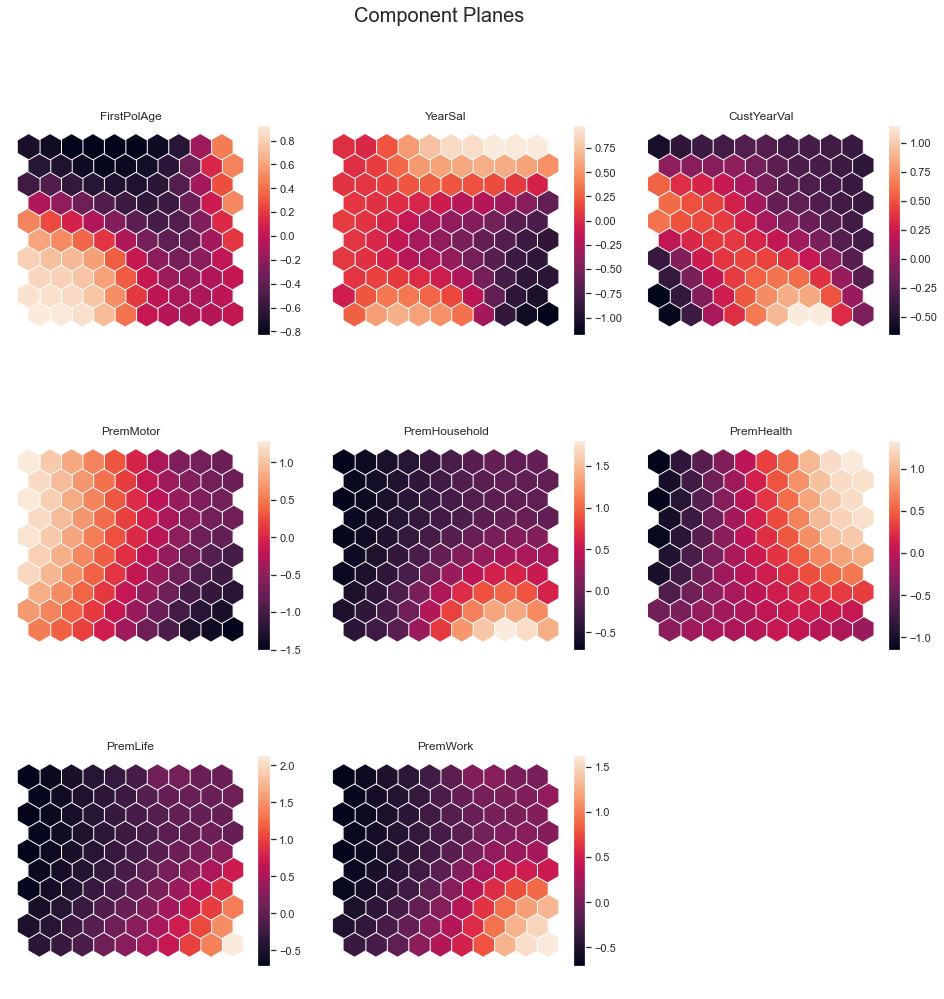

In [92]:
# This visualization gives us an idea of the average feature value in different regions of the input space

sns.set()
view2D = View2D(12, 12, "", text_size=10)
view2D.show(sm, col_sz=3, what='codebook')
plt.subplots_adjust(top=0.90)
plt.suptitle("Component Planes", fontsize=20)
plt.show()

In [93]:
# This Component planes gives us useful information regarding feature importance
# If a component plane has many collors, this proves that we have feature variation

# We can also check for correlation --> Premwork and PremLife are spatial correlated (PrimeHousehold aswell) because they have same values in the same space of the input space

# This is also useful to check for potential outliers --> later using hitmap

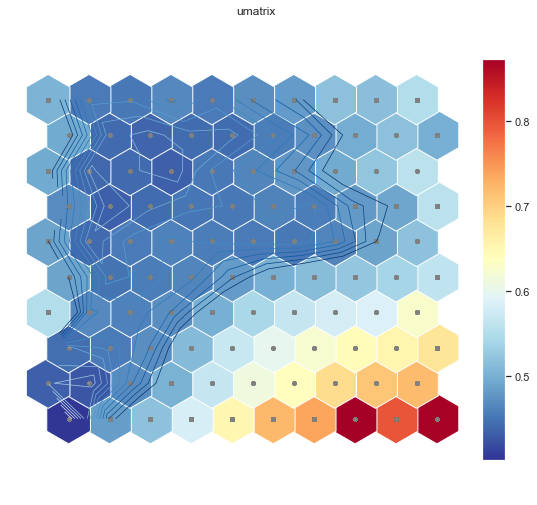

array([[0.50344922, 0.45325637, 0.45222972, 0.46571995, 0.45398479,
        0.47115536, 0.4809033 , 0.51618392, 0.51405505, 0.55070336],
       [0.49468564, 0.44080419, 0.43713295, 0.44275976, 0.44346742,
        0.45653021, 0.47220118, 0.49641932, 0.51625939, 0.49982305],
       [0.49494287, 0.43867631, 0.44062148, 0.43373211, 0.45212105,
        0.46293765, 0.47595037, 0.49458274, 0.52216355, 0.55716153],
       [0.46914684, 0.43446435, 0.44380452, 0.44987188, 0.45202215,
        0.46072408, 0.45631569, 0.48071616, 0.49119665, 0.55730055],
       [0.48936466, 0.44083571, 0.4536655 , 0.45909067, 0.45633786,
        0.45408322, 0.45296738, 0.4640885 , 0.48858954, 0.51785032],
       [0.48872498, 0.44773757, 0.45558062, 0.46237165, 0.48154044,
        0.49925196, 0.51246932, 0.52428655, 0.53932385, 0.56082226],
       [0.54934961, 0.46550067, 0.45880003, 0.47067902, 0.49937262,
        0.54267109, 0.56688984, 0.5795501 , 0.58584891, 0.62672038],
       [0.44400677, 0.45362397, 0.4708718

In [94]:
# U matrix to check for potential clusters and outliers

u = sompy.umatrix.UMatrixView(9, 9, 'umatrix', show_axis=True, text_size=8, show_text=True)

UMAT = u.show(
    sm, 
    distance=2, 
    row_normalized=False,
    show_data=True, 
    contour=True, 
    blob=False
)

np.flip(UMAT[1], axis=1)

In [95]:
# The units located in the right lower section of the Umatrix are really far away from the other units.
# This may be indication of potential outliers and also and also a lower probability of forming a cluster in that area
# This matches the average feature distribution of the PremLife, Premwork and PremHousehold

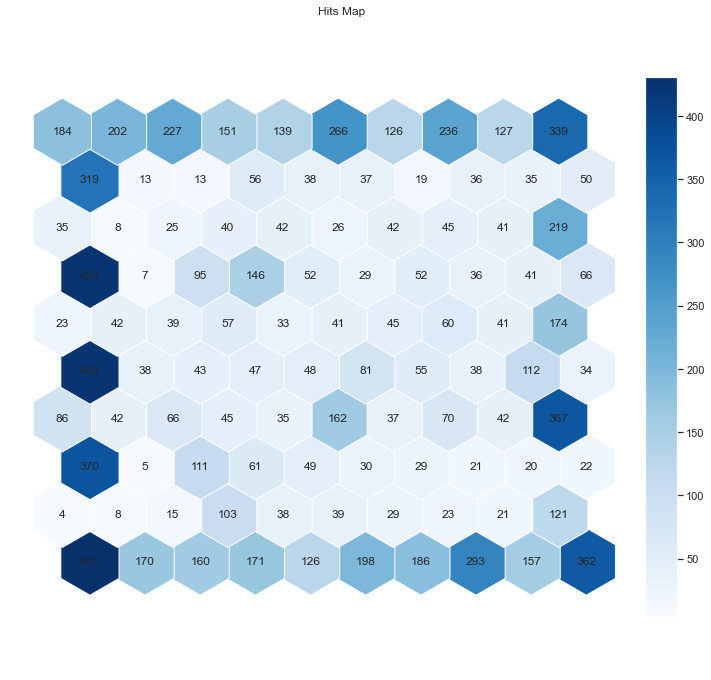

In [96]:
vhts  = BmuHitsView(12,12,"Hits Map")
vhts.show(sm, anotate=True, onlyzeros=False, labelsize=12, cmap="Blues")
plt.show()

# Clustering by Perspectives

In [97]:
# Split variables into perspectives

# x0 education
# x1 GeoLivArea
# x2 children


premium_features = [
    'PremMotor',
    'PremHousehold',
    'PremHealth',
    'PremLife',
    'PremWork',
]

demographic_features = [
    'YearSal',
    'x0_2',
    'x0_3', 
    'x0_4',
    'x1_2.0', 
    'x1_3.0',
    'x1_4.0',
    'x2_1.0'
]
categorical= (1,2,3,4,5,6,7)

contract_features = [
    'CustYearVal',
    'FirstPolAge', 
    
]

df_pr = df[premium_features].copy()
df_dem = df[demographic_features].copy()
df_ct = df[contract_features].copy()

In [98]:
def get_r2_scores_kp(df, clusterer, min_k=1, max_k=10):
    """
    Loop over different values of k. To be used with sklearn clusterers.
    """
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df, categorical= (1,2,3,4,5,6,7))
        r2_clust[n] = r2_(df, labels)
    return r2_clust

def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

def r2_(df, labels):
    sst = get_ss(df)
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst
    
def get_r2_scores(df, clusterer, min_k=1, max_k=10):
    """
    Loop over different values of k. To be used with sklearn clusterers.
    """
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        r2_clust[n] = r2_(df, labels)
    return r2_clust

### Premium Perspective

### Defining the optimal number of clusters

In [99]:
# Applying Kmeans on a high number of clusters

kmclust = KMeans(n_clusters=20, init='k-means++', n_init=15, random_state=1)
kmclust.fit_predict(df_pr)

array([ 3,  6, 19, ...,  9, 13,  9])

In [100]:
centroids = kmclust.cluster_centers_
centroids

array([[0.4936121 , 0.09017275, 0.5145446 , 0.07458923, 0.07764941],
       [0.32564382, 0.27400929, 0.47910812, 0.1099201 , 0.11150357],
       [0.89670142, 0.04175473, 0.11875546, 0.02964032, 0.03191047],
       [0.61151251, 0.12055498, 0.26763972, 0.12848333, 0.09629596],
       [0.24670429, 0.1208151 , 0.75151175, 0.10842348, 0.10316877],
       [0.79272791, 0.05591674, 0.21107541, 0.04787386, 0.0462341 ],
       [0.11310816, 0.34929488, 0.26655467, 0.53526431, 0.16870241],
       [0.17879612, 0.34831676, 0.41193769, 0.28938862, 0.14506812],
       [0.19787081, 0.15368132, 0.62203317, 0.25714255, 0.1364035 ],
       [0.70357699, 0.06333454, 0.31121651, 0.0545937 , 0.05142599],
       [0.49885858, 0.11459362, 0.39038888, 0.1533361 , 0.10062792],
       [0.18708299, 0.14043051, 0.46415632, 0.44047221, 0.16306434],
       [0.43192348, 0.20544523, 0.31334362, 0.1066335 , 0.19753425],
       [0.36622529, 0.11804611, 0.49679917, 0.2013308 , 0.12473687],
       [0.60373101, 0.07133631, 0.

In [101]:
# 5 coordenates for each feature

df_centroids = pd.DataFrame(centroids)
df_centroids

,0,1,2,3,4
0,0.493612,0.090173,0.514545,0.074589,0.077649
1,0.325644,0.274009,0.479108,0.109920,0.111504
2,0.896701,0.041755,0.118755,0.029640,0.031910
3,0.611513,0.120555,0.267640,0.128483,0.096296
4,0.246704,0.120815,0.751512,0.108423,0.103169
5,0.792728,0.055917,0.211075,0.047874,0.046234
6,0.113108,0.349295,0.266555,0.535264,0.168702
7,0.178796,0.348317,0.411938,0.289389,0.145068
8,0.197871,0.153681,0.622033,0.257143,0.136404
9,0.703577,0.063335,0.311217,0.054594,0.051426


In [102]:
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, affinity= distance, distance_threshold=0, n_clusters=None)
hc_labels = hclust.fit_predict(df_centroids)
hc_labels

array([18, 12, 17, 15, 11, 19,  9, 10, 13, 16,  8, 14,  6,  7,  5,  2,  3,
        4,  1,  0], dtype=int64)

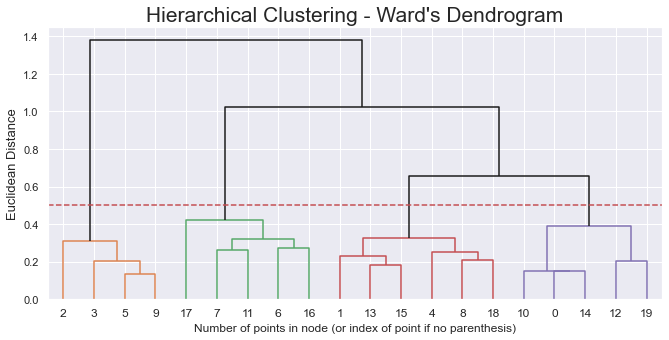

In [103]:
# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 0.5
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

In [104]:
# 4 clusters

For n_clusters = 4, the average silhouette_score is : 0.3512806922164775


([<matplotlib.axis.XTick at 0x27d93aea430>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

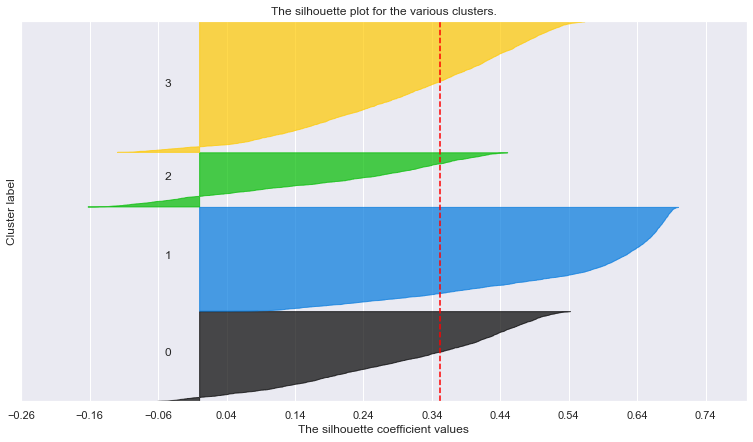

In [105]:
# Storing average silhouette metric
avg_silhouette = []
nclus = 4
# Create a figure
fig = plt.figure(figsize=(13, 7))

# Initialize the KMeans object with n_clusters value and a random generator
# seed of 10 for reproducibility.
kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
cluster_labels = kmclust.fit_predict(df_pr)

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed clusters
silhouette_avg = silhouette_score(df_pr, cluster_labels)
avg_silhouette.append(silhouette_avg)
print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(df_pr, cluster_labels)

y_lower = 10
for i in range(nclus):
    # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
        
    # Get y_upper to demarcate silhouette y range size
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
        
    # Filling the silhouette
    color = cm.nipy_spectral(float(i) / nclus)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

plt.title("The silhouette plot for the various clusters.")
plt.xlabel("The silhouette coefficient values")
plt.ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
# The silhouette coefficient can range from -1, 1
xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
plt.xlim([xmin, xmax])
    
# The (nclus+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
plt.ylim([0, len(df_pr) + (nclus + 1) * 10])

plt.yticks([])  # Clear the yaxis labels / ticks
plt.xticks(np.arange(xmin, xmax, 0.1))

In [106]:
#getting r2 score

In [107]:
# Obtaining the R² scores for solution 4 on premium variables
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(df_pr, kmclust, min_k=4, max_k=5)

pd.DataFrame(r2_scores)

,kmeans
4,0.727189


### Hierarchical

For n_clusters = 4, the average silhouette_score is : 0.31164341974900595


([<matplotlib.axis.XTick at 0x27d93b6a610>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

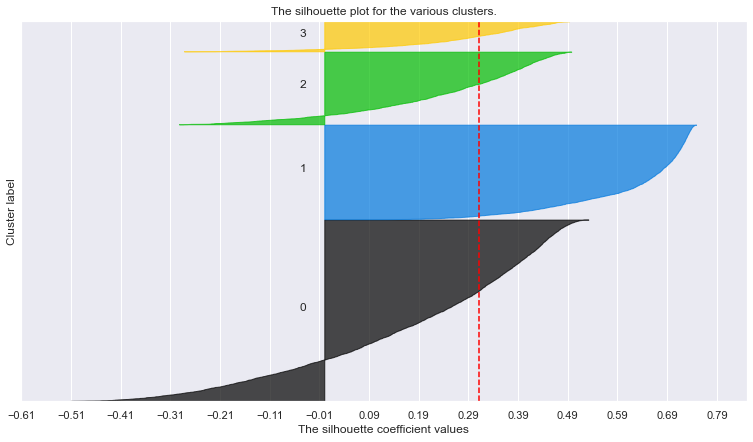

In [108]:
# Storing average silhouette metric
avg_silhouette = []
n_clus = 4
# Create a figure
fig = plt.figure(figsize=(13, 7))

# Initialize the KMeans object with n_clusters value and a random generator
# seed of 10 for reproducibility.

linkage = 'ward'
distance = 'euclidean'

hcclust = AgglomerativeClustering(linkage=linkage, affinity= distance, n_clusters=n_clus)
cluster_labels = hcclust.fit_predict(df_pr)

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed clusters
silhouette_avg = silhouette_score(df_pr, cluster_labels)
avg_silhouette.append(silhouette_avg)
print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(df_pr, cluster_labels)

y_lower = 10
for i in range(nclus):
    # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
        
    # Get y_upper to demarcate silhouette y range size
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
        
    # Filling the silhouette
    color = cm.nipy_spectral(float(i) / nclus)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

plt.title("The silhouette plot for the various clusters.")
plt.xlabel("The silhouette coefficient values")
plt.ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
# The silhouette coefficient can range from -1, 1
xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
plt.xlim([xmin, xmax])
    
# The (nclus+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
plt.ylim([0, len(df_pr) + (nclus + 1) * 10])

plt.yticks([])  # Clear the yaxis labels / ticks
plt.xticks(np.arange(xmin, xmax, 0.1))

In [109]:
# Obtaining the R² scores for solution 4 on premium variables
r2_scores = {}
r2_scores['ward'] = get_r2_scores(df_pr, hcclust, min_k=4, max_k=5)

pd.DataFrame(r2_scores)

,ward
4,0.680129


In [110]:
#dbscan é sempre 1/2 clusters não vale a pena fazer silhouete

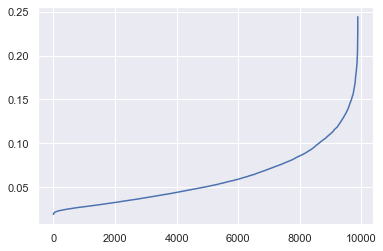

In [111]:
# K-distance graph to find out the right eps value
neigh = NearestNeighbors(n_neighbors=20)
neigh.fit(df_pr)
distances, _ = neigh.kneighbors(df_pr)
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.show()

### DBSCAN

In [112]:
dbscan = DBSCAN(eps=0.10, min_samples=10, n_jobs=-1)
dbscan_labels = dbscan.fit_predict(df_pr)


In [113]:
# Concatenating the labels to df
df_concat = pd.concat([df_pr, pd.Series(dbscan_labels, index=df_pr.index, name="dbscan_labels")], axis=1)
df_concat.head()

# Detecting noise (potential outliers)
print("noise: "+str(len(df_concat.loc[df_concat['dbscan_labels'] == -1])))

# Computing the R^2 of the cluster solution
df_nonoise = df_concat.loc[df_concat['dbscan_labels'] != -1]
sst = get_ss(df_pr)  # get total sum of squares
ssw_labels = df_nonoise.groupby(by='dbscan_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

noise: 251
Cluster solution with R^2 of 0.0897


### SOM

In [114]:
# This som implementation does not have a random seed parameter
# We're going to set it up ourselves
np.random.seed(42)

# Notice that the SOM did not converge - We're under a time constraint for this class
sm = sompy.SOMFactory().build(
    df_pr.values, 
    mapsize=[50, 50],  # NEEDS TO BE A LIST
    initialization='random',
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
)
sm.train(n_job=-1, train_rough_len=100, train_finetune_len=100)

 Training...
 random_initialization took: 0.000000 seconds
 Rough training...
 radius_ini: 17.000000 , radius_final: 2.833333, trainlen: 100

 epoch: 1 ---> elapsed time:  0.187000, quantization error: 0.904768

 epoch: 2 ---> elapsed time:  0.206000, quantization error: 1.984279

 epoch: 3 ---> elapsed time:  0.208000, quantization error: 1.928690

 epoch: 4 ---> elapsed time:  0.203000, quantization error: 1.922453

 epoch: 5 ---> elapsed time:  0.208000, quantization error: 1.920071

 epoch: 6 ---> elapsed time:  0.204000, quantization error: 1.917803

 epoch: 7 ---> elapsed time:  0.206000, quantization error: 1.914931

 epoch: 8 ---> elapsed time:  0.208000, quantization error: 1.911671

 epoch: 9 ---> elapsed time:  0.211000, quantization error: 1.906870

 epoch: 10 ---> elapsed time:  0.212000, quantization error: 1.900298

 epoch: 11 ---> elapsed time:  0.211000, quantization error: 1.897634

 epoch: 12 ---> elapsed time:  0.212000, quantization error: 1.895890

 epoch: 13 --->

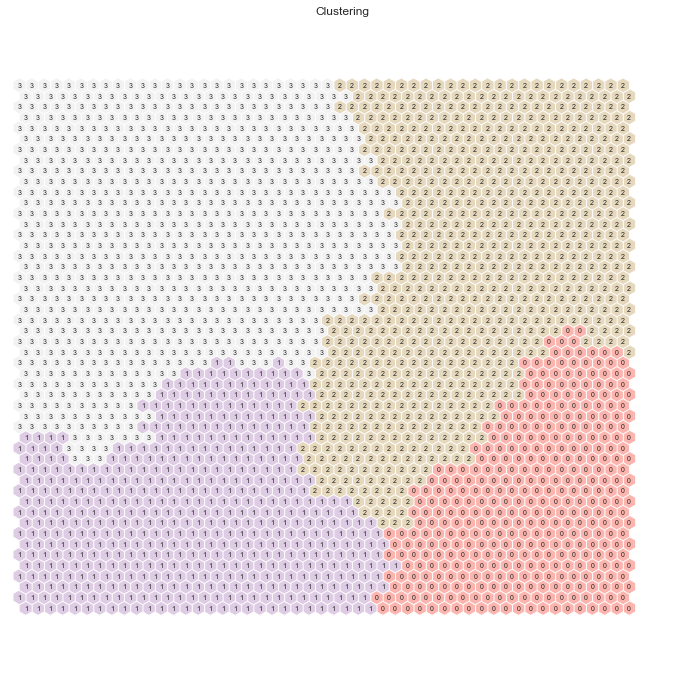

In [115]:
# Perform K-Means clustering on top of the 2500 untis (sm.get_node_vectors() output)
hc = AgglomerativeClustering(n_clusters=4, linkage='ward')
nodeclus_labels = hc.fit_predict(sm.codebook.matrix)
sm.cluster_labels = nodeclus_labels  # setting the cluster labels of sompy

hits = HitMapView(12, 12,"Clustering", text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

In [116]:
nodes = sm.codebook.matrix
df_nodes = pd.DataFrame(nodes)
df_nodes['label'] = nodeclus_labels
sst = get_ss(df_nodes)  # get total sum of squares
ssw_labels = df_nodes.groupby(by='label').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
r2 

0.6897389685589562

# best

In [117]:
kmeans = kmclust.fit_predict(df_pr)
cluster_dict=[]
for c in kmeans:
    cluster_dict.append(c)

In [118]:
df['cluster'] = cluster_dict

<AxesSubplot:xlabel='PC0', ylabel='PC1'>

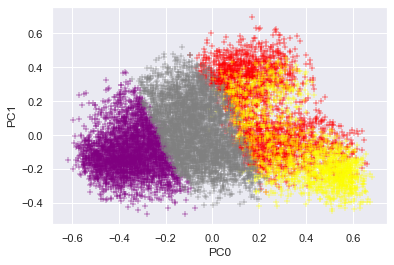

In [119]:
sns.scatterplot(x = 'PC0', y= 'PC1', data = df[df['cluster'] == 0], marker = '+', color = 'red')
sns.scatterplot(x = 'PC0', y= 'PC1', data = df[df['cluster'] == 1], marker = '+', color = 'purple')
sns.scatterplot(x = 'PC0', y= 'PC1', data = df[df['cluster'] == 2], marker = '+', color = 'yellow')
sns.scatterplot(x = 'PC0', y= 'PC1', data = df[df['cluster'] == 3], marker = '+', color = 'grey')

### Demographic Perspective

### Optimal Number of clusters

In [120]:
kpclust = KP(n_clusters=20, init='Huang', n_init=15, random_state=1, n_jobs = -1)
kpclust.fit_predict(df_dem, categorical = categorical)

array([16,  0,  8, ..., 19, 11, 14], dtype=uint16)

In [121]:
centroids = kpclust.cluster_centroids_
centroids

array([[0.37582085, 1.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 1.        ],
       [0.25840556, 0.        , 1.        , 0.        , 0.        ,
        1.        , 0.        , 1.        ],
       [0.55982815, 0.        , 1.        , 0.        , 0.        ,
        1.        , 0.        , 1.        ],
       [0.47092041, 0.        , 0.        , 1.        , 0.        ,
        0.        , 1.        , 1.        ],
       [0.72957563, 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.70323285, 0.        , 1.        , 0.        , 0.        ,
        0.        , 1.        , 0.        ],
       [0.71452025, 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.42540052, 0.        , 1.        , 0.        , 1.        ,
        0.        , 0.        , 1.        ],
       [0.69718165, 1.        , 0.        , 0.        , 0.        ,
        1.        , 0.      

In [122]:
# 8 coordenates for each feature

df_centroids = pd.DataFrame(centroids)
df_centroids

,0,1,2,3,4,5,6,7
0,0.375821,1.0,0.0,0.0,0.0,0.0,1.0,1.0
1,0.258406,0.0,1.0,0.0,0.0,1.0,0.0,1.0
2,0.559828,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,0.470920,0.0,0.0,1.0,0.0,0.0,1.0,1.0
4,0.729576,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,0.703233,0.0,1.0,0.0,0.0,0.0,1.0,0.0
6,0.714520,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,0.425401,0.0,1.0,0.0,1.0,0.0,0.0,1.0
8,0.697182,1.0,0.0,0.0,0.0,1.0,0.0,0.0
9,0.205994,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [123]:
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, affinity= distance, distance_threshold=0, n_clusters=None)
hc_labels = hclust.fit_predict(df_centroids)
hc_labels

array([13, 19, 16, 14, 17, 10, 18,  9, 11,  6, 15, 12,  8,  5,  2,  7,  4,
        3,  1,  0], dtype=int64)

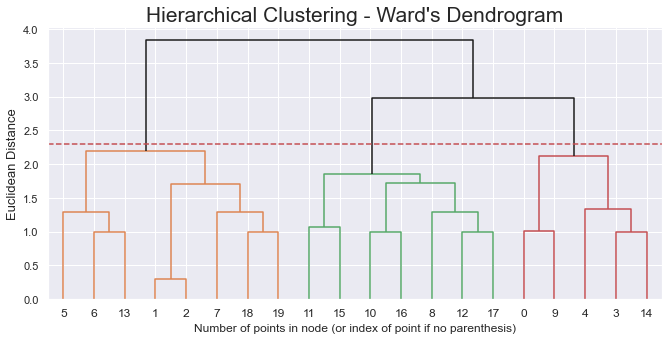

In [124]:
# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 2.3
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

In [125]:
# 3 clusters

### KPrototypes

For n_clusters = 3, the average silhouette_score is : 0.2331251678741119


([<matplotlib.axis.XTick at 0x27d933a8310>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

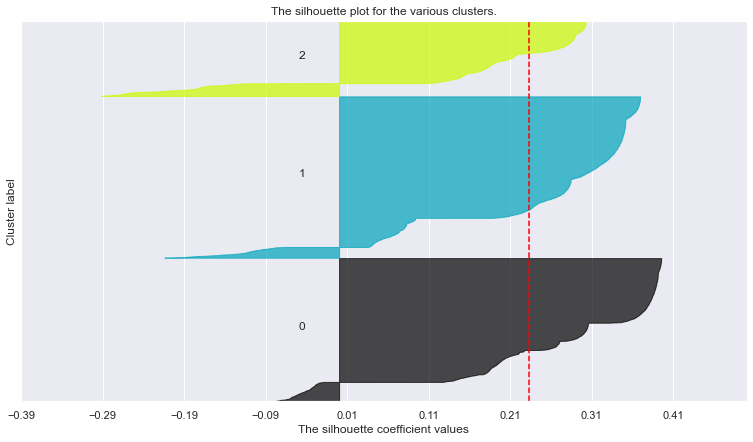

In [126]:
# Storing average silhouette metric
avg_silhouette = []
nclus = 3
# Create a figure
fig = plt.figure(figsize=(13, 7))

# Initialize the KMeans object with n_clusters value and a random generator
# seed of 10 for reproducibility.

linkage = 'ward'
distance = 'euclidean'

kpclust = KP(n_clusters=nclus, init='Huang', verbose=0, n_jobs = -1, random_state=1, n_init = 15)
cluster_labels = kpclust.fit_predict(df_dem, categorical = categorical)

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed clusters
silhouette_avg = silhouette_score(df_dem, cluster_labels)
avg_silhouette.append(silhouette_avg)
print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(df_dem, cluster_labels)

y_lower = 10
for i in range(nclus):
    # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
        
    # Get y_upper to demarcate silhouette y range size
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
        
    # Filling the silhouette
    color = cm.nipy_spectral(float(i) / nclus)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

plt.title("The silhouette plot for the various clusters.")
plt.xlabel("The silhouette coefficient values")
plt.ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
# The silhouette coefficient can range from -1, 1
xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
plt.xlim([xmin, xmax])
    
# The (nclus+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
plt.ylim([0, len(df_dem) + (nclus + 1) * 10])

plt.yticks([])  # Clear the yaxis labels / ticks
plt.xticks(np.arange(xmin, xmax, 0.1))

In [127]:
# Obtaining the R² scores for solution 4 on premium variables
kp = KP(init='Huang', verbose=0, n_jobs = -1, random_state=1, n_init = 15)
r2_scores = {}
r2_scores['Kprototype'] = get_r2_scores_kp(df_dem, kp, min_k=4, max_k=5)

pd.DataFrame(r2_scores)


,Kprototype
4,0.432968


### Hierarchical clustering

For n_clusters = 3, the average silhouette_score is : 0.3023657444258106


([<matplotlib.axis.XTick at 0x27d940110d0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

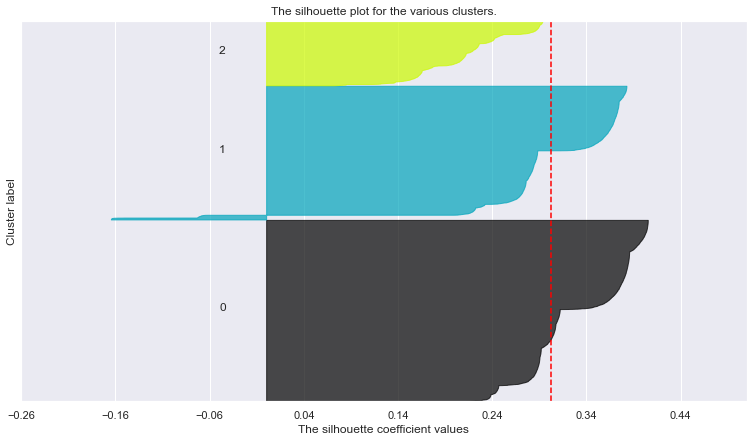

In [128]:
# Storing average silhouette metric
avg_silhouette = []
n_clus = 3
# Create a figure
fig = plt.figure(figsize=(13, 7))

# Initialize the KMeans object with n_clusters value and a random generator
# seed of 10 for reproducibility.

linkage = 'ward'
distance = 'euclidean'

hcclust = AgglomerativeClustering(linkage=linkage, affinity= distance, n_clusters=n_clus)
cluster_labels = hcclust.fit_predict(df_dem)

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed clusters
silhouette_avg = silhouette_score(df_dem, cluster_labels)
avg_silhouette.append(silhouette_avg)
print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(df_dem, cluster_labels)

y_lower = 10
for i in range(nclus):
    # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
        
    # Get y_upper to demarcate silhouette y range size
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
        
    # Filling the silhouette
    color = cm.nipy_spectral(float(i) / nclus)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

plt.title("The silhouette plot for the various clusters.")
plt.xlabel("The silhouette coefficient values")
plt.ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
# The silhouette coefficient can range from -1, 1
xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
plt.xlim([xmin, xmax])
    
# The (nclus+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
plt.ylim([0, len(df_dem) + (nclus + 1) * 10])

plt.yticks([])  # Clear the yaxis labels / ticks
plt.xticks(np.arange(xmin, xmax, 0.1))

In [129]:
# Obtaining the R² scores for solution 4 on premium variables
r2_scores = {}
r2_scores['ward'] = get_r2_scores(df_dem, hcclust, min_k=4, max_k=5)

pd.DataFrame(r2_scores)

,ward
4,0.455157


### Contract Perspective

### Optimal Number of clusters

In [130]:
# Applying Kmeans on a high number of clusters

kmclust = KMeans(n_clusters=20, init='k-means++', n_init=15, random_state=1)
kmclust.fit_predict(df_ct)

array([ 5,  9, 13, ..., 13,  3,  1])

In [131]:
centroids = kmclust.cluster_centers_
centroids

array([[0.87852331, 0.99976913],
       [0.90525522, 0.99976553],
       [0.92605332, 0.99975778],
       [0.89204379, 0.99976579],
       [0.87582579, 0.99977394],
       [0.89893865, 0.99976652],
       [0.73658752, 0.99963328],
       [0.91294913, 0.99975663],
       [0.88151478, 0.99976398],
       [0.86933686, 0.99977289],
       [0.94598387, 0.99974801],
       [0.88483063, 0.99976805],
       [0.89564815, 0.99976692],
       [0.90879243, 0.9997609 ],
       [0.88850296, 0.99977082],
       [0.91881514, 0.99976598],
       [0.93551104, 0.99977818],
       [0.87316032, 0.99976745],
       [0.90196997, 0.9997746 ],
       [0.86258258, 0.99974125]])

In [132]:
# 2 coordenates for each feature

df_centroids = pd.DataFrame(centroids)
df_centroids

,0,1
0,0.878523,0.999769
1,0.905255,0.999766
2,0.926053,0.999758
3,0.892044,0.999766
4,0.875826,0.999774
5,0.898939,0.999767
6,0.736588,0.999633
7,0.912949,0.999757
8,0.881515,0.999764
9,0.869337,0.999773


In [133]:
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, affinity= distance, distance_threshold=0, n_clusters=None)
hc_labels = hclust.fit_predict(df_centroids)
hc_labels

array([18, 16, 10, 15, 19, 17,  7, 12,  9, 11, 13, 14,  6,  8,  3,  5,  2,
        4,  1,  0], dtype=int64)

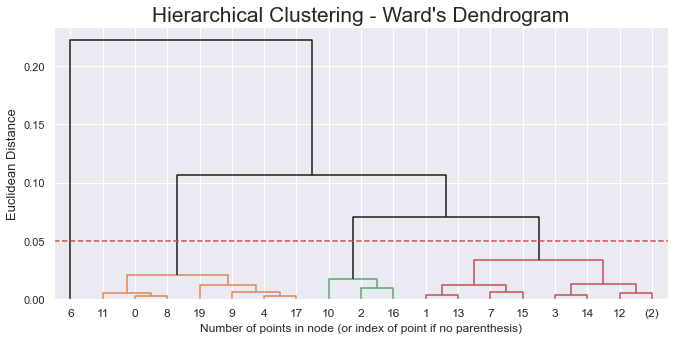

In [134]:
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 0.05
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

In [135]:
# 4 clusters

In [136]:
# aqui!

For n_clusters = 4, the average silhouette_score is : 0.5964499668115066


([<matplotlib.axis.XTick at 0x27da13cee20>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

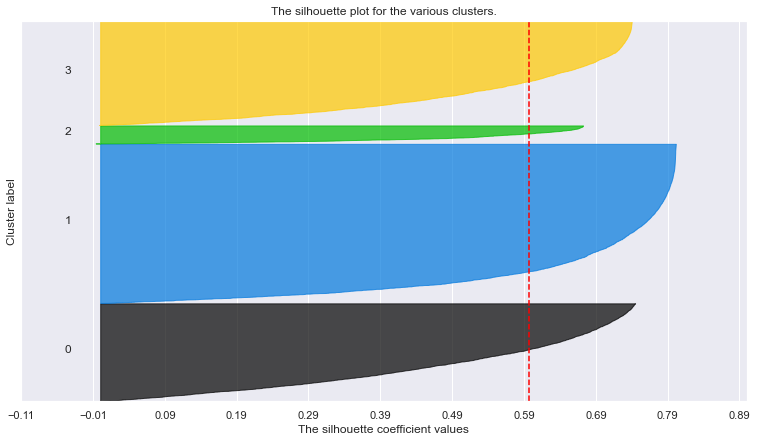

In [137]:
# Storing average silhouette metric
avg_silhouette = []
nclus = 4
# Create a figure
fig = plt.figure(figsize=(13, 7))

# Initialize the KMeans object with n_clusters value and a random generator
# seed of 10 for reproducibility.
kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
cluster_labels = kmclust.fit_predict(df_ct)

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed clusters
silhouette_avg = silhouette_score(df_ct, cluster_labels)
avg_silhouette.append(silhouette_avg)
print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(df_ct, cluster_labels)

y_lower = 10
for i in range(nclus):
    # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
        
    # Get y_upper to demarcate silhouette y range size
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
        
    # Filling the silhouette
    color = cm.nipy_spectral(float(i) / nclus)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

plt.title("The silhouette plot for the various clusters.")
plt.xlabel("The silhouette coefficient values")
plt.ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
# The silhouette coefficient can range from -1, 1
xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
plt.xlim([xmin, xmax])
    
# The (nclus+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
plt.ylim([0, len(df_ct) + (nclus + 1) * 10])

plt.yticks([])  # Clear the yaxis labels / ticks
plt.xticks(np.arange(xmin, xmax, 0.1))

In [138]:
#getting r2 score

In [139]:
# Obtaining the R² scores for solution 4 on premium variables
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(df_ct, kmclust, min_k=4, max_k=5)

pd.DataFrame(r2_scores)

,kmeans
4,0.892757


### Hierarchical

For n_clusters = 4, the average silhouette_score is : 0.5715356115143507


([<matplotlib.axis.XTick at 0x27d99b53730>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

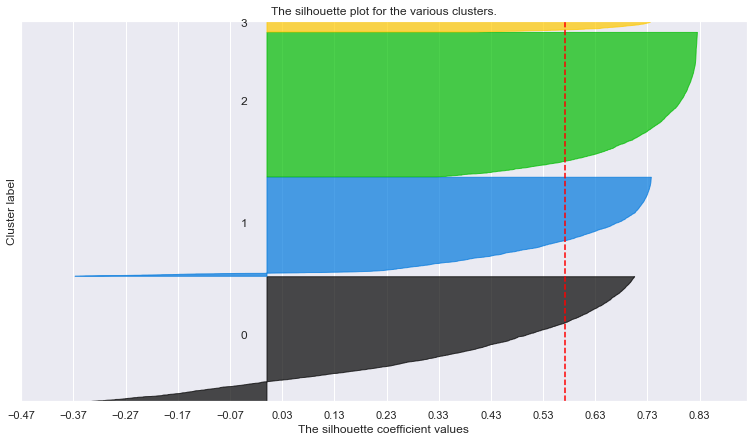

In [140]:
# Storing average silhouette metric
avg_silhouette = []
n_clus = 4
# Create a figure
fig = plt.figure(figsize=(13, 7))

# Initialize the KMeans object with n_clusters value and a random generator
# seed of 10 for reproducibility.

linkage = 'ward'
distance = 'euclidean'

hcclust = AgglomerativeClustering(linkage=linkage, affinity= distance, n_clusters=n_clus)
cluster_labels = hcclust.fit_predict(df_ct)

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed clusters
silhouette_avg = silhouette_score(df_ct, cluster_labels)
avg_silhouette.append(silhouette_avg)
print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(df_ct, cluster_labels)

y_lower = 10
for i in range(nclus):
    # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
        
    # Get y_upper to demarcate silhouette y range size
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
        
    # Filling the silhouette
    color = cm.nipy_spectral(float(i) / nclus)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

plt.title("The silhouette plot for the various clusters.")
plt.xlabel("The silhouette coefficient values")
plt.ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
# The silhouette coefficient can range from -1, 1
xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
plt.xlim([xmin, xmax])
    
# The (nclus+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
plt.ylim([0, len(df_ct) + (nclus + 1) * 10])

plt.yticks([])  # Clear the yaxis labels / ticks
plt.xticks(np.arange(xmin, xmax, 0.1))

In [141]:
# Obtaining the R² scores for solution 4 on premium variables
r2_scores = {}
r2_scores['ward'] = get_r2_scores(df_ct, hcclust, min_k=4, max_k=5)

pd.DataFrame(r2_scores)

,ward
4,0.880531


In [142]:
#dbscan é sempre 1/2 clusters não vale a pena fazer silhouete

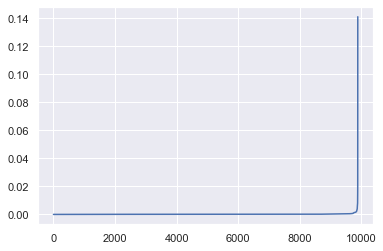

In [143]:
# K-distance graph to find out the right eps value
neigh = NearestNeighbors(n_neighbors=20)
neigh.fit(df_ct)
distances, _ = neigh.kneighbors(df_ct)
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.show()

### DBSCAN

In [144]:
dbscan = DBSCAN(eps=0.10, min_samples=10, n_jobs=-1)
dbscan_labels = dbscan.fit_predict(df_ct)


In [145]:
# Concatenating the labels to df
df_concat = pd.concat([df_ct, pd.Series(dbscan_labels, index=df_ct.index, name="dbscan_labels")], axis=1)
df_concat.head()

# Detecting noise (potential outliers)
print("noise: "+str(len(df_concat.loc[df_concat['dbscan_labels'] == -1])))

# Computing the R^2 of the cluster solution
df_nonoise = df_concat.loc[df_concat['dbscan_labels'] != -1]
sst = get_ss(df_ct)  # get total sum of squares
ssw_labels = df_nonoise.groupby(by='dbscan_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print("Cluster solution with R^2 of %0.4f" % r2)

noise: 1
Cluster solution with R^2 of 0.0132


### SOM

In [146]:
# This som implementation does not have a random seed parameter
# We're going to set it up ourselves
np.random.seed(42)

# Notice that the SOM did not converge - We're under a time constraint for this class
sm = sompy.SOMFactory().build(
    df_ct.values, 
    mapsize=[50, 50],  # NEEDS TO BE A LIST
    initialization='random',
    neighborhood='gaussian',
    training='batch',
    lattice='hexa',
)
sm.train(n_job=-1, train_rough_len=100, train_finetune_len=100)

 Training...
 random_initialization took: 0.000000 seconds
 Rough training...
 radius_ini: 17.000000 , radius_final: 2.833333, trainlen: 100

 epoch: 1 ---> elapsed time:  0.185000, quantization error: 0.076715

 epoch: 2 ---> elapsed time:  0.197000, quantization error: 1.298257

 epoch: 3 ---> elapsed time:  0.197000, quantization error: 1.252880

 epoch: 4 ---> elapsed time:  0.202000, quantization error: 1.248711

 epoch: 5 ---> elapsed time:  0.197000, quantization error: 1.246630

 epoch: 6 ---> elapsed time:  0.204000, quantization error: 1.245183

 epoch: 7 ---> elapsed time:  0.205000, quantization error: 1.243228

 epoch: 8 ---> elapsed time:  0.199000, quantization error: 1.241421

 epoch: 9 ---> elapsed time:  0.201000, quantization error: 1.240206

 epoch: 10 ---> elapsed time:  0.202000, quantization error: 1.239055

 epoch: 11 ---> elapsed time:  0.192000, quantization error: 1.237892

 epoch: 12 ---> elapsed time:  0.201000, quantization error: 1.236701

 epoch: 13 --->

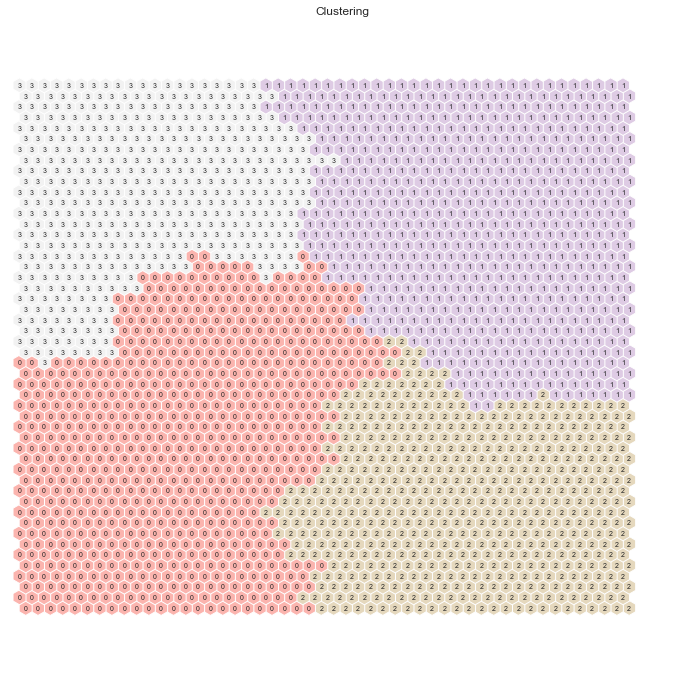

In [147]:
# Perform K-Means clustering on top of the 2500 untis (sm.get_node_vectors() output)
hc = AgglomerativeClustering(n_clusters=4, linkage='ward')
nodeclus_labels = hc.fit_predict(sm.codebook.matrix)
sm.cluster_labels = nodeclus_labels  # setting the cluster labels of sompy

hits = HitMapView(12, 12,"Clustering", text_size=10)
hits.show(sm, anotate=True, onlyzeros=False, labelsize=7, cmap="Pastel1")

plt.show()

In [148]:
nodes = sm.codebook.matrix
df_nodes = pd.DataFrame(nodes)
df_nodes['label'] = nodeclus_labels
sst = get_ss(df_nodes)  # get total sum of squares
ssw_labels = df_nodes.groupby(by='label').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
r2 

0.8335287526034152

# best

In [149]:
kmeans = kmclust.fit_predict(df_ct)
cluster_dict=[]
for c in kmeans:
    cluster_dict.append(c)

In [150]:
df['cluster'] = cluster_dict

<AxesSubplot:xlabel='PC0', ylabel='PC1'>

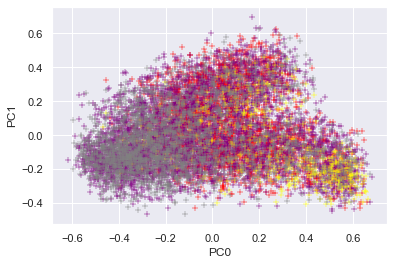

In [151]:
sns.scatterplot(x = 'PC0', y= 'PC1', data = df[df['cluster'] == 0], marker = '+', color = 'red')
sns.scatterplot(x = 'PC0', y= 'PC1', data = df[df['cluster'] == 1], marker = '+', color = 'purple')
sns.scatterplot(x = 'PC0', y= 'PC1', data = df[df['cluster'] == 2], marker = '+', color = 'yellow')
sns.scatterplot(x = 'PC0', y= 'PC1', data = df[df['cluster'] == 3], marker = '+', color = 'grey')

# Merge

In [152]:
#best pr kmeans
#best dem ward
#best ct kmeans

In [153]:
kmeans_pr = KMeans(n_clusters = 4, n_init = 15, random_state = 1) 
pr_labels = kmeans_pr.fit_predict(df_pr)

linkage = 'ward'
distance = 'euclidean'

ward_dem = AgglomerativeClustering(linkage=linkage, affinity= distance, n_clusters=3)
dem_labels = ward_dem.fit_predict(df_dem)

kmeans_ct = KMeans(n_clusters = 4, n_init = 15, random_state = 1) 
ct_labels = kmeans_ct.fit_predict(df_ct)

df['premium_labels'] = pr_labels
df['demographic_labels'] = dem_labels
df['contract_labels'] = ct_labels

In [154]:
del df['cluster']

In [155]:
# Count label frequencies (contigency table)
a = df.groupby(['premium_labels', 'demographic_labels', 'contract_labels'])\
    .size()\
    .to_frame()\
    .reset_index()

In [156]:
pivot = pd.pivot_table(
    data=a,
    index=['premium_labels','demographic_labels','contract_labels'],
    aggfunc='sum'
)

In [157]:
pivot.head(60)

0
premium_labels demographic_labels contract_labels     
0              0                  0                425
                                  1                408
                                  2                 21
                                  3                176
               1                  0                380
                                  1                427
                                  2                 42
                                  3                172
               2                  0                116
                                  1                120
                                  2                 11
                                  3                 47
1              0                  0                 71
                                  1                810
                                  2                 12
                                  3                756
               1                  0                 45
                                  1                327
                                  2                 10
                                  3                275
               2                  0                 18
                                  1                191
                                  2                  4
                                  3                192
2              0                  0                 37
                                  1                 63
                                  2                 42
                                  3                 47
               1                  0                185
                                  1                259
                                  2                122
                                  3                122
               2                  0                123
                                  1                201
                                  2                123
                                  3                 91
3              0                  0                622
                                  1                742
                                  2                 34
                                  3                456
               1                  0                378
                                  1                435
                                  2                 36
                                  3                273
               2                  0                148
                                  1                171
                                  2                 13
                                  3                104

In [158]:
pivot.tail(3)

0
premium_labels demographic_labels contract_labels     
3              2                  1                171
                                  2                 13
                                  3                104

In [159]:
(pivot[0]).mean()

205.89583333333334

In [160]:
(pivot[0]).median()

123.0

In [161]:
pivot.count()

0    48
dtype: int64

In [162]:
pivot[(pivot[0] > 205)].count()

0    15
dtype: int64

### Merging using Hierarchical clustering

In [163]:
# Centroids of the concatenated cluster labels
df_centroids = df.groupby(['premium_labels','demographic_labels','contract_labels'])\
    [metric_features].mean()
df_centroids

FirstPolAge   YearSal  \
premium_labels demographic_labels contract_labels                          
0              0                  0                   0.999771  0.502567   
                                  1                   0.999775  0.491704   
                                  2                   0.999740  0.365726   
                                  3                   0.999774  0.480773   
               1                  0                   0.999761  0.465261   
                                  1                   0.999761  0.477240   
                                  2                   0.999737  0.445799   
                                  3                   0.999769  0.476569   
               2                  0                   0.999756  0.507988   
                                  1                   0.999766  0.475728   
                                  2                   0.999779  0.462205   
                                  3                   0.999750  0.438848   
1              0                  0                   0.999780  0.471906   
                                  1                   0.999770  0.487959   
                                  2                   0.999738  0.535978   
                                  3                   0.999765  0.477784   
               1                  0                   0.999784  0.511268   
                                  1                   0.999771  0.495237   
                                  2                   0.999824  0.508980   
                                  3                   0.999766  0.491291   
               2                  0                   0.999777  0.516709   
                                  1                   0.999767  0.463907   
                                  2                   0.999778  0.550768   
                                  3                   0.999771  0.493511   
2              0                  0                   0.999746  0.384530   
                                  1                   0.999755  0.331117   
                                  2                   0.999728  0.344324   
                                  3                   0.999751  0.361512   
               1                  0                   0.999765  0.363368   
                                  1                   0.999770  0.322324   
                                  2                   0.999775  0.319628   
                                  3                   0.999749  0.411731   
               2                  0                   0.999765  0.303265   
                                  1                   0.999765  0.262235   
                                  2                   0.999767  0.228754   
                                  3                   0.999761  0.294624   
3              0                  0                   0.999767  0.512618   
                                  1                   0.999768  0.506326   
                                  2                   0.999779  0.508614   
                                  3                   0.999768  0.484339   
               1                  0                   0.999773  0.489541   
                                  1                   0.999773  0.490523   
                                  2                   0.999758  0.501102   
                                  3                   0.999772  0.496861   
               2                  0                   0.999779  0.492365   
                                  1                   0.999779  0.504427   
                                  2                   0.999782  0.416957   
                                  3                   0.999766  0.508975   

                                                   CustYearVal  PremMotor  \
premium_labels demographic_labels contract_labels                           
0              0                  0                   0.890395   0.357520   
                   

In [164]:
# Using Hierarchical clustering to merge the concatenated cluster centroids
hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)
hclust_labels = hclust.fit_predict(df_centroids)

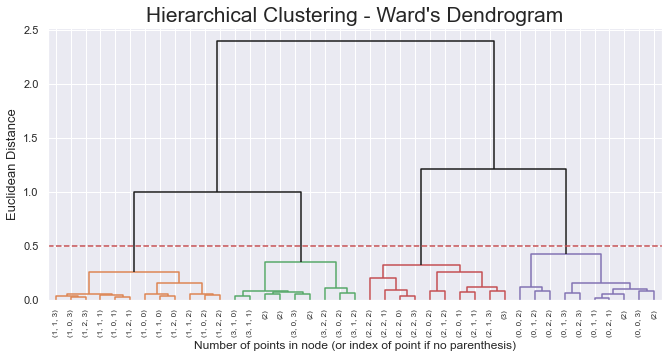

In [165]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 0.5
dendrogram(linkage_matrix, truncate_mode='level', labels=df_centroids.index, p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()

In [166]:
# Re-running the Hierarchical clustering based on the correct number of clusters
hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    n_clusters=4
)
hclust_labels = hclust.fit_predict(df_centroids)
df_centroids['hclust_labels'] = hclust_labels

df_centroids  # centroid's cluster labels

FirstPolAge   YearSal  \
premium_labels demographic_labels contract_labels                          
0              0                  0                   0.999771  0.502567   
                                  1                   0.999775  0.491704   
                                  2                   0.999740  0.365726   
                                  3                   0.999774  0.480773   
               1                  0                   0.999761  0.465261   
                                  1                   0.999761  0.477240   
                                  2                   0.999737  0.445799   
                                  3                   0.999769  0.476569   
               2                  0                   0.999756  0.507988   
                                  1                   0.999766  0.475728   
                                  2                   0.999779  0.462205   
                                  3                   0.999750  0.438848   
1              0                  0                   0.999780  0.471906   
                                  1                   0.999770  0.487959   
                                  2                   0.999738  0.535978   
                                  3                   0.999765  0.477784   
               1                  0                   0.999784  0.511268   
                                  1                   0.999771  0.495237   
                                  2                   0.999824  0.508980   
                                  3                   0.999766  0.491291   
               2                  0                   0.999777  0.516709   
                                  1                   0.999767  0.463907   
                                  2                   0.999778  0.550768   
                                  3                   0.999771  0.493511   
2              0                  0                   0.999746  0.384530   
                                  1                   0.999755  0.331117   
                                  2                   0.999728  0.344324   
                                  3                   0.999751  0.361512   
               1                  0                   0.999765  0.363368   
                                  1                   0.999770  0.322324   
                                  2                   0.999775  0.319628   
                                  3                   0.999749  0.411731   
               2                  0                   0.999765  0.303265   
                                  1                   0.999765  0.262235   
                                  2                   0.999767  0.228754   
                                  3                   0.999761  0.294624   
3              0                  0                   0.999767  0.512618   
                                  1                   0.999768  0.506326   
                                  2                   0.999779  0.508614   
                                  3                   0.999768  0.484339   
               1                  0                   0.999773  0.489541   
                                  1                   0.999773  0.490523   
                                  2                   0.999758  0.501102   
                                  3                   0.999772  0.496861   
               2                  0                   0.999779  0.492365   
                                  1                   0.999779  0.504427   
                                  2                   0.999782  0.416957   
                                  3                   0.999766  0.508975   

                                                   CustYearVal  PremMotor  \
premium_labels demographic_labels contract_labels                           
0              0                  0                   0.890395   0.357520   
                   

In [167]:
# Mapper between concatenated clusters and hierarchical clusters
cluster_mapper = df_centroids['hclust_labels'].to_dict()

df_ = df.copy()

# Mapping the hierarchical clusters on the centroids to the observations
df_['merged_labels'] = df_.apply(
    lambda row: cluster_mapper[
        (row['premium_labels'], row['demographic_labels'], row['contract_labels'])
    ], axis=1
)
# Merged cluster centroids
df_.groupby('merged_labels').mean()[metric_features]

,FirstPolAge,YearSal,CustYearVal,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
merged_labels,,,,,,,,
0,0.999766,0.481663,0.888386,0.326079,0.131984,0.601421,0.134632,0.115270
1,0.999770,0.498910,0.889700,0.559970,0.100423,0.387823,0.100211,0.084696
2,0.999763,0.319032,0.895112,0.207371,0.257952,0.363781,0.312529,0.218482
3,0.999769,0.485576,0.890237,0.802232,0.055166,0.203237,0.045878,0.044267


In [168]:
#Merge cluster contigency table
# Getting size of each final cluster
df_counts = df_.groupby('merged_labels')\
    .size()\
    .to_frame()

# Getting the product and behavior labels
df_counts = df_counts\
    .rename({v:k for k, v in cluster_mapper.items()})\
    .reset_index()

df_counts['premium_labels'] = df_counts['merged_labels'].apply(lambda x: x[0])
df_counts['demographic_labels'] = df_counts['merged_labels'].apply(lambda x: x[1])
df_counts['contract_labels'] = df_counts['merged_labels'].apply(lambda x: x[2])

pivot = pd.pivot_table(
    data=df_counts,
    index=['premium_labels','demographic_labels','contract_labels'],
    aggfunc='sum'
)

In [169]:
pivot

,,,0
premium_labels,demographic_labels,contract_labels,
0,2,3,2345
1,2,3,2711
2,2,3,1415
3,2,3,3412


In [170]:
# Setting df to have the final product, behavior and merged clusters
df = df_.copy()

## Cluster Analysis

In [171]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) # Adaptable to number of clusters
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=23)
    plt.show()

### interpreting categorical variables

In [172]:
df.groupby('merged_labels')[non_metric_features].mean()

,x0_2,x0_3,x0_4,x1_2.0,x1_3.0,x1_4.0,x2_1.0
merged_labels,,,,,,,
0,0.427719,0.439232,0.035821,0.095949,0.192751,0.413220,0.536461
1,0.320047,0.543376,0.070633,0.101114,0.201055,0.407093,0.713658
2,0.465018,0.133569,0.004240,0.088339,0.214134,0.409894,0.656537
3,0.225747,0.608263,0.131686,0.102176,0.205828,0.392106,0.884544


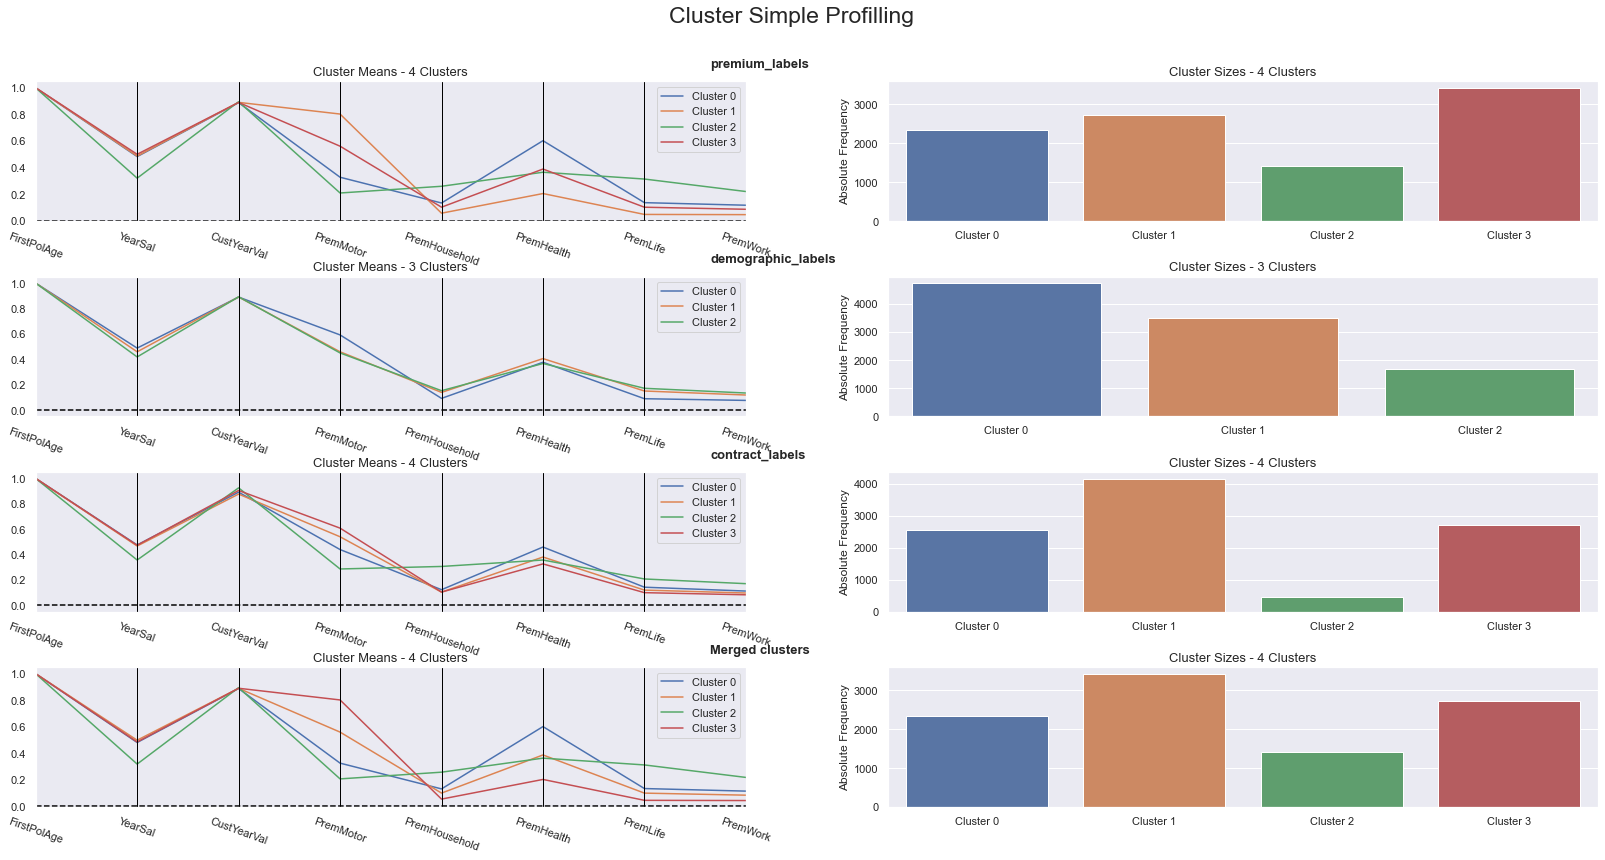

In [173]:
# Profilling each cluster
cluster_profiles(
    df = df[metric_features.to_list() + ['premium_labels','demographic_labels','contract_labels', 'merged_labels']], 
    label_columns = ['premium_labels','demographic_labels','contract_labels', 'merged_labels'], 
    figsize = (28, 13), 
    compar_titles = ['premium_labels','demographic_labels','contract_labels', "Merged clusters"]
)

In [174]:
# This is step can be quite time consuming
two_dim = TSNE(random_state=42).fit_transform(df[metric_features])

C:\Users\Ricardo\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Ricardo\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


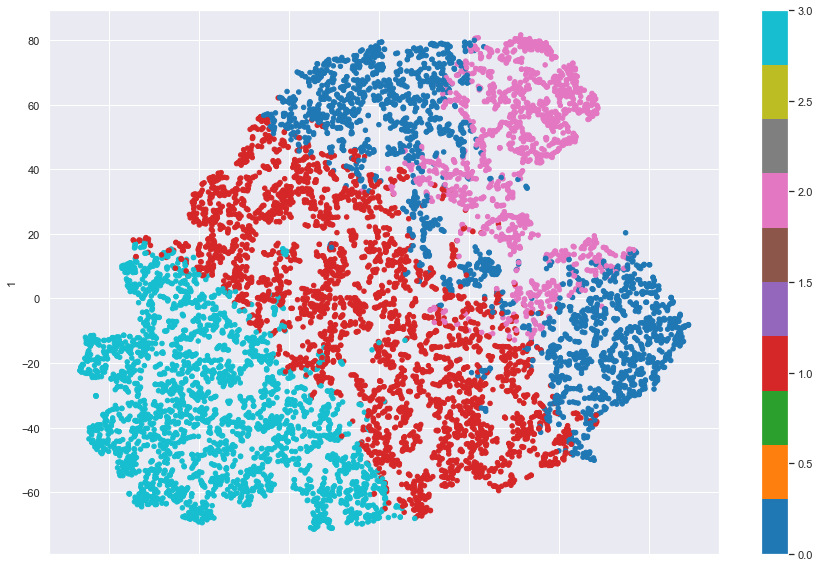

In [175]:
# t-SNE visualization
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=df['merged_labels'], colormap='tab10', figsize=(15,10))
plt.show()

## Assess feature importance and reclassify outliers

In [176]:
def get_ss_variables(df):
    """Get the SS for each variable
    """
    ss_vars = df.var() * (df.count() - 1)
    return ss_vars

def r2_variables(df, labels):
    """Get the R² for each variable
    """
    sst_vars = get_ss_variables(df)
    ssw_vars = np.sum(df.groupby(labels).apply(get_ss_variables))
    return 1 - ssw_vars/sst_vars

In [177]:
# We are essentially decomposing the R² into the R² for each variable
r2_variables(df[metric_features.to_list() + ['merged_labels']], 'merged_labels').drop('merged_labels')

FirstPolAge      0.000437
YearSal          0.084228
CustYearVal      0.019402
PremMotor        0.859466
PremHousehold    0.464294
PremHealth       0.728722
PremLife         0.525590
PremWork         0.431865
dtype: float64

### Using a Decision Tree
We get the normalized total reduction of the criterion (gini or entropy) brought by that feature (also known as Gini importance).

In [178]:
# Preparing the data
X = df.drop(columns=['premium_labels','demographic_labels','contract_labels','merged_labels'])
y = df.merged_labels

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fitting the decision tree
dt = DecisionTreeClassifier(random_state=42, max_depth=3)
dt.fit(X_train, y_train)
print("It is estimated that in average, we are able to predict {0:.2f}% of the customers correctly".format(dt.score(X_test, y_test)*100))

It is estimated that in average, we are able to predict 90.64% of the customers correctly


In [179]:
# Assessing feature importance
pd.Series(dt.feature_importances_, index=X_train.columns)

FirstPolAge      0.000000
YearSal          0.000000
CustYearVal      0.000000
PremMotor        0.779976
PremHousehold    0.000000
PremHealth       0.220024
PremLife         0.000000
PremWork         0.000000
x0_2             0.000000
x0_3             0.000000
x0_4             0.000000
x1_2.0           0.000000
x1_3.0           0.000000
x1_4.0           0.000000
x2_1.0           0.000000
PC0              0.000000
PC1              0.000000
PC2              0.000000
dtype: float64

In [180]:
# Predicting the cluster labels of the outliers
df_out['merged_labels'] = dt.predict(df_out)
df_out.head()

,FirstPolAge,YearSal,CustYearVal,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,x0_2,x0_3,x0_4,x1_2.0,x1_3.0,x1_4.0,x2_1.0,PC0,PC1,PC2,merged_labels
CustID,,,,,,,,,,,,,,,,,,,
52,0.999846,0.618814,0.000000,0.952862,0.041327,0.071173,0.032242,0.005928,0.0,1.0,0.0,0.0,0.0,1.0,1.0,-0.572007,-0.057008,0.107421,3
99,0.999730,0.754480,0.888192,0.353571,0.068646,0.251995,0.517169,0.141632,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.096751,0.223825,0.380301,2
102,0.999865,0.503626,0.916558,0.113332,0.314715,0.477021,0.103310,0.332009,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.411495,0.143615,0.097676,0
113,0.999556,0.431101,0.357525,0.886481,0.034562,0.130368,0.029260,0.045228,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.436102,-0.190456,0.023252,3
136,0.999556,0.393131,0.269271,0.511971,0.103448,0.326921,0.385486,0.017783,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.050315,-0.088543,0.092886,1


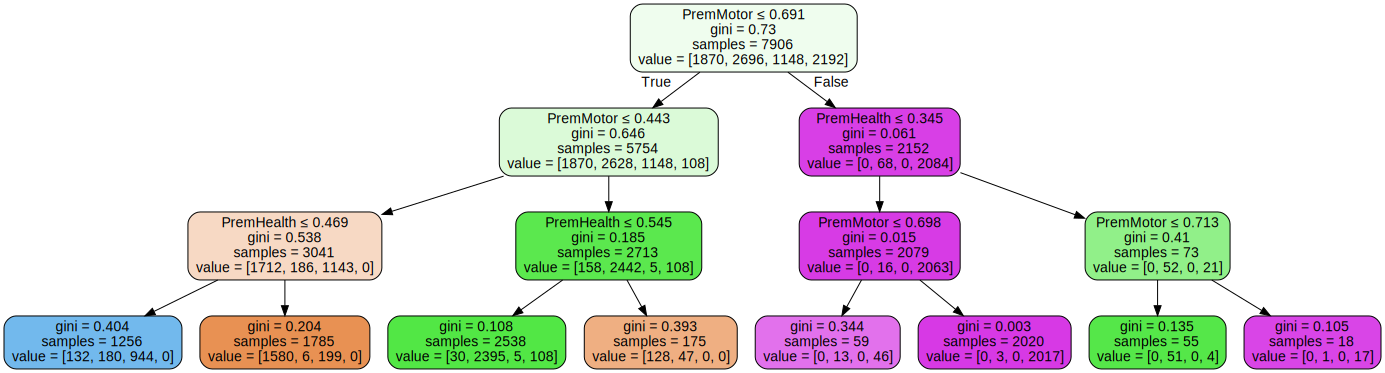

In [181]:
# Visualizing the decision tree
dot_data = export_graphviz(dt, out_file=None, 
                           feature_names=X.columns.to_list(),
                           filled=True,
                           rounded=True,
                           special_characters=True)  
graphviz.Source(dot_data)